<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/draft/Fact_data_ajustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 inamura先生に聞きたいこと \\
 ・けん玉の難易度の変更は何を決め手に決定しているのか？ \\
 ・変更なしと変更ありの被験者番号は同一人物なのか？ \\


In [2]:
# GoogleドライブをGoogle Colabにマウント
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [3]:
#pandasをインポート
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'

In [55]:
class Kendama_analyze():
  def __init__(self, original_pattern, number_people):
    self.original_pattern = original_pattern #ファイルのリンクを格納
    self.number_people = number_people #どれだけのデータ数を使用するかを決定する変数

  #被験者一人の解析を行う関数
  def start_analyze(self, Kendama_file_path,division, pattern):
    #成功した時と失敗した時の処理を行うコード
    dispersion = np.empty((0,2))     #被験者のやる気を表す分散を格納する配列
    Abs_degree_failure = np.array([])
    x = np.array([])  #試行回数を格納
    success = 0
    srate = np.array([])
    succ_check = True
    abs_degree_failure_sum = 0
    variance_x_sum = 0
    variance_y_sum = 0
    success_sum = 0
    abs_degree_failure = 0
    variance_x = 0.01
    variance_y = 0.01
    #他の初期値の宣言を書く（abs_degree_failureなど）
    for i in range(len(Kendama_file_path)):
      data_check = True #dataが正しいのかのチェックを行う。もし、おかしければ１つ前の施工データを使用するようにする
      if "fail" in Kendama_file_path[i]:
        succ_check = False
      else:
        succ_check = True
      df=pd.read_csv(Kendama_file_path[i],engine='python') #CSVファイルのパスを指定

      for index, row in df.iterrows(): #1行目から順番に内容を取得している処理
        if i == 0:
          p = np.array([[row['sword.Position.x'],row['sword.Position.y']]]) #皿のガウス分布の平均値を格納する配列
        if succ_check: #成功した時
          if abs(row['ball.Position.y'] - row['sword.Position.y']) <= 0.05: #玉がplateに乗っているもしくは直前かどうか
            data_check = False
            p = np.append(p, [[row['sword.Position.x'],row['sword.Position.y']]], axis = 0) #plateの原点を次回の平均値に入れる
            abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
            abs_degree_failure_sum += abs_degree_failure
            variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y = (row['sword.Position.y']-p[i][1])**2
            variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y_sum += variance_y
            success_sum += 1
            # sigma = sigma/alpha
            break
        else: #失敗した時
          if abs(row['ball.Position.y'] - row['sword.Position.y']) <= 0.1: #玉がplateに乗っているもしくは直前かどうか
            data_check = False
            p = np.append(p, [[row['ball.Position.x'],row['ball.Position.y']]], axis = 0) #玉の落下位置を次回の平均値に入れる
            abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
            abs_degree_failure_sum += abs_degree_failure
            variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y = (row['sword.Position.y']-p[i][1])**2 #このコードは分散とは言えない
            variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y_sum += variance_y
            # sigma = sigma*beta
            break
      if data_check: #dataに何らかの不備があった場合の応急処置のコード
        p = np.append(p, [p[i]], axis = 0)
        abs_degree_failure_sum += abs_degree_failure
        variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
        variance_y_sum += variance_y

      if (i+1)%division == 0: #divisionによっていくつごとに平均を取るか決まる
        dispersion = np.append(dispersion, [[variance_x_sum/division,variance_y_sum/division]], axis=0)
        Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure_sum/division)
        abs_degree_failure_sum = 0
        variance_x_sum = 0
        variance_y_sum = 0
        #divisionが１だと0％か１００％になるため例外処理を埋め込んでいる
        if division != 1 or pattern != "default":
          srate = np.append(srate, (success_sum/division)*100)
          success_sum = 0
        else:
          srate = np.append(srate, (success_sum/(i+1))*100)
        x =np.append(x, (i+1)//division)

    # x.append(len(Kendama_file_path))
    p = np.delete(p, 0, axis=0)
    return x,p,dispersion,Abs_degree_failure,srate

  #指定した幅での平均を使った解析
  def divided_analyze(self, division, width, pattern, difficulty_levels):
    A_x_L = np.empty((0,int(20-width)))
    A_p_L = np.empty((0,20-width,2))
    A_dispersion_L = np.empty((0,int(20-width),2))
    A_Abs_degree_failure_L = np.empty((0,int(20-width)))
    A_srate_L = np.empty((0,int(20-width)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1から10までの数字でループ
      for level in difficulty_levels[f'{j}']:
        # new_number = '{:02d}'.format(i)  # 2桁の数字にフォーマット
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')  # 数字部分を置換
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path) #ファイルの順番がおかしいので並び替えを行うコード

        x,p,dispersion,Abs_degree_failure,srate = self.start_analyze(Kendama_file_path, division, pattern)

        #新しい配列に1つずつずらした5つの値の平均を入れる
        new_x = x[0:(len(x)-width)]
        new_p = np.array([np.mean(p[i:i+width, :], axis=0) for i in range(20-width)])
        new_dispersion = np.array([np.mean(dispersion[i:i+width, :], axis=0) for i in range(20-width)])
        new_Abs_degree_failure = np.array([np.mean(Abs_degree_failure[i:i+width]) for i in range(20-width)])
        #確率は要修正（divisionが１の場合累計の成功率になっているため）
        new_srate = np.array([np.mean(srate[i:i+width]) for i in range(20-width)])


        A_x_L = np.append(A_x_L, [new_x], axis = 0)
        A_p_L = np.append(A_p_L, [new_p], axis = 0)
        A_dispersion_L = np.append(A_dispersion_L, [new_dispersion], axis = 0)
        A_Abs_degree_failure_L = np.append(A_Abs_degree_failure_L, [new_Abs_degree_failure], axis = 0)
        A_srate_L = np.append(A_srate_L, [new_srate], axis = 0)

    return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L

  #指定した人数分解析のループを行う関数
  def loop_analyze(self, division, pattern, difficulty_levels):
    A_x_L = np.empty((0,int(20/division)))
    A_p_L = np.empty((0,20,2))
    A_dispersion_L = np.empty((0,int(20/division),2))
    A_Abs_degree_failure_L = np.empty((0,int(20/division)))
    A_srate_L = np.empty((0,int(20/division)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1からnumber_peopleまでの数字でループ
      for level in difficulty_levels[f'{j}']: #fはフォーマットでjの値を入れている
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path)  # ファイルの順番を並び替え

        x, p, dispersion, Abs_degree_failure, srate = self.start_analyze(Kendama_file_path, division, pattern)

        A_x_L = np.append(A_x_L, [x], axis=0)
        A_p_L = np.append(A_p_L, [p], axis=0)  # 要素が21個あるため先頭の要素を削るコードが必要かも？
        A_dispersion_L = np.append(A_dispersion_L, [dispersion], axis=0)
        A_Abs_degree_failure_L = np.append(A_Abs_degree_failure_L, [Abs_degree_failure], axis=0)
        A_srate_L = np.append(A_srate_L, [srate], axis=0)

    return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L


In [63]:
class Kendama_show(Kendama_analyze):
  def __init__(self, original_pattern, number_people):
    super().__init__(original_pattern, number_people)
    self.colors = {
    'srate': 'orange',
    'abs': 'r',
    'dispersion': 'b',
    'R': 'g'
    }

  def make_result(self, difficulty_levels ,division, pattern, width=None):
    if pattern == "default":
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.loop_analyze(division, pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L
    else:
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.divided_analyze(division, width,pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L

  def show_result(self, A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, n):
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": A_Abs_degree_failure_L, "color": 'r', "ylabel": 'degree failure', "ylim": (0, 0.4)},
        "Success rate(%)": {"data": A_srate_L, "color": 'orange', "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X^2,σ_Y^2": {"data": abs(np.sqrt(A_dispersion_L[:,:,0]+A_dispersion_L[:,:,1])), "color": 'green', "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.3)},
        "σ_X^2": {"data": A_dispersion_L[:,:,0], "color": 'b', "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": A_dispersion_L[:,:,1], "color": 'b', "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column, 3, figsize=(40, column*3+1), sharex=True)

    for i in range(3):
        for j, (label, props) in enumerate(data_dict.items()):
          if j >= column:
            break
          axs[j, i].plot(A_x_L[i+n], props["data"][i+n], linewidth=4, color=props["color"], marker="o")
          axs[j, i].set_ylabel(props["ylabel"])
          axs[j, i].set_ylim(props["ylim"])
          axs[j, i].set_xticks(np.arange(1*(5//division), 5*(5//division) - width, 1*(5//division)))

          # if division == 5:
          #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
          # else:
          #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1

          axs[j, i].set_xlabel("t (times)")

    plt.tight_layout()
    # plt.savefig(f"data_fitting_10.png")
    # files.download(f'data_fitting_10.png')
    plt.show()


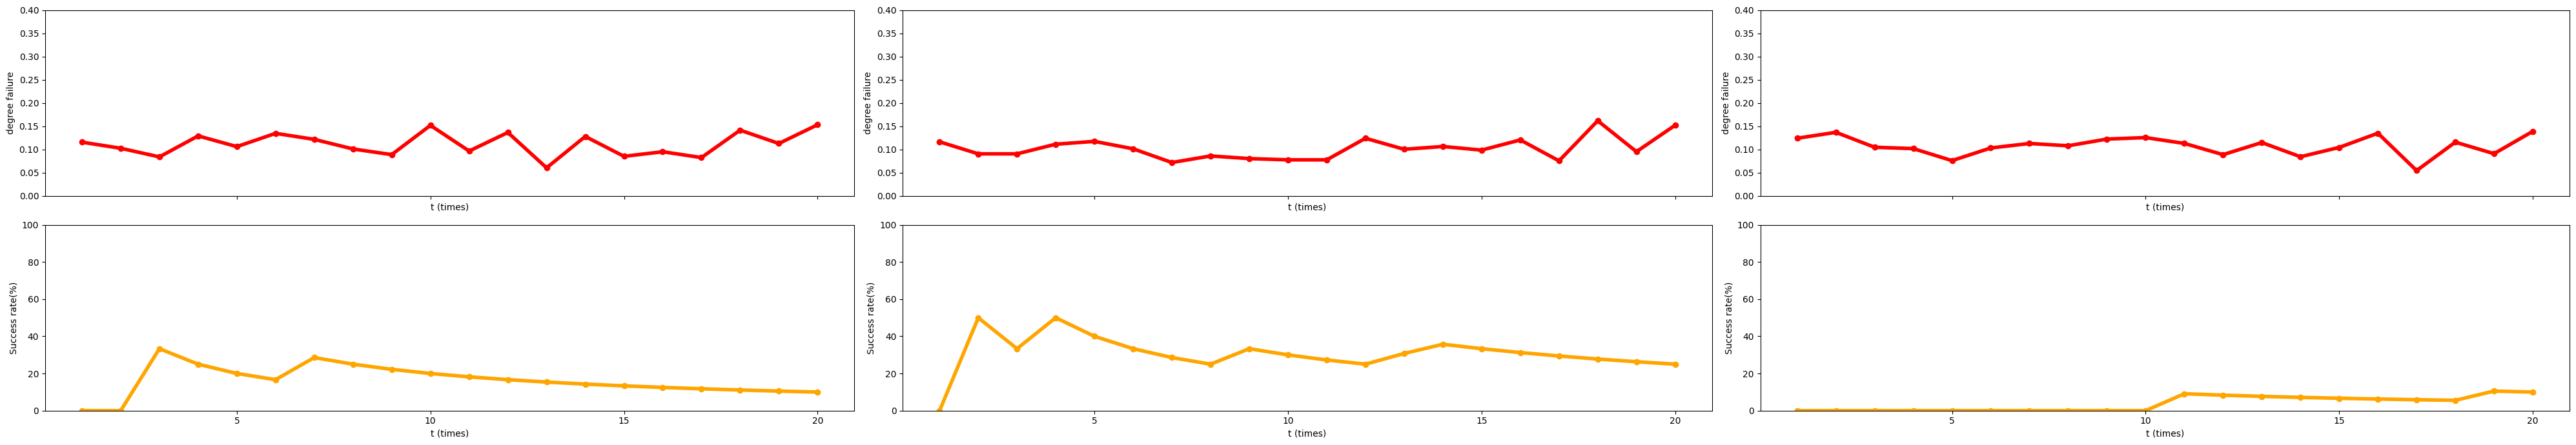

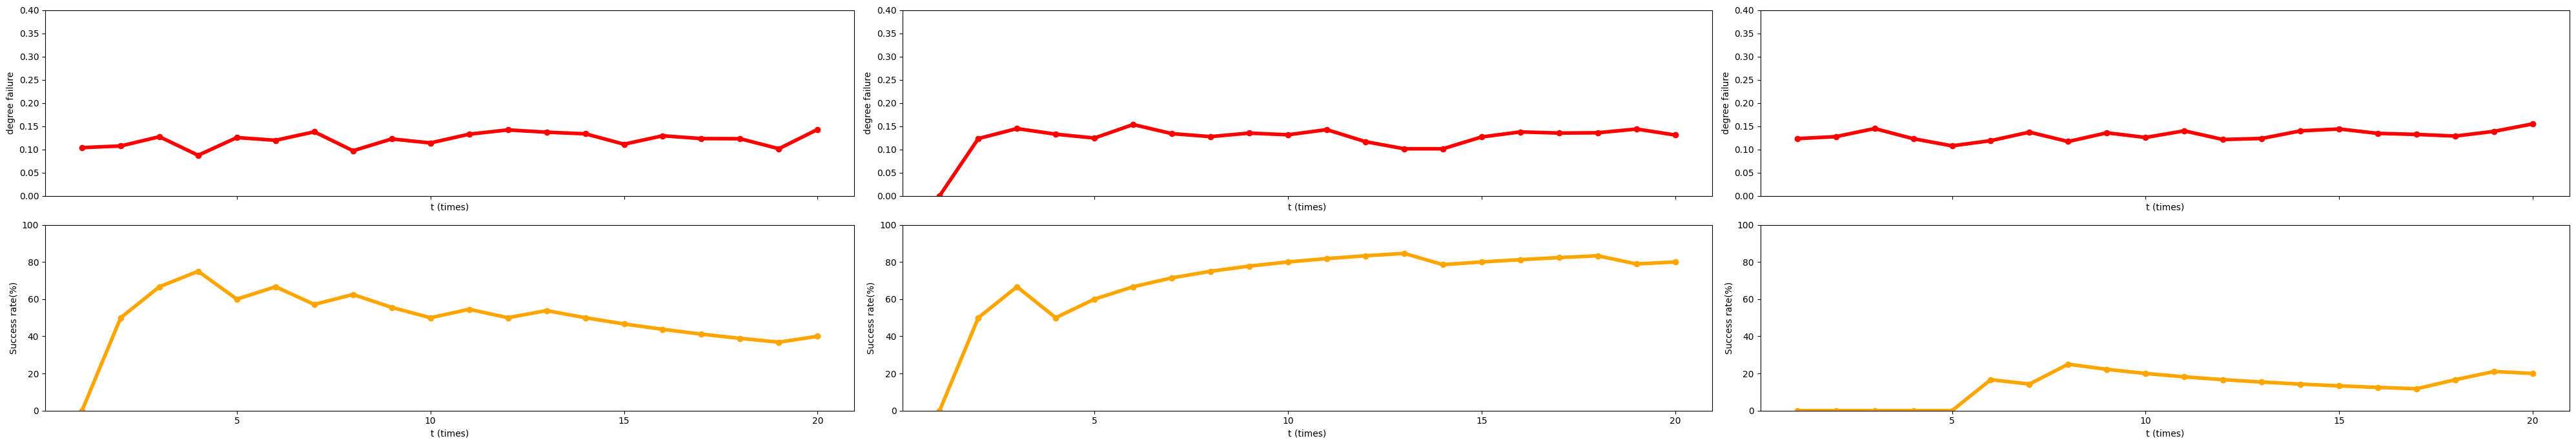

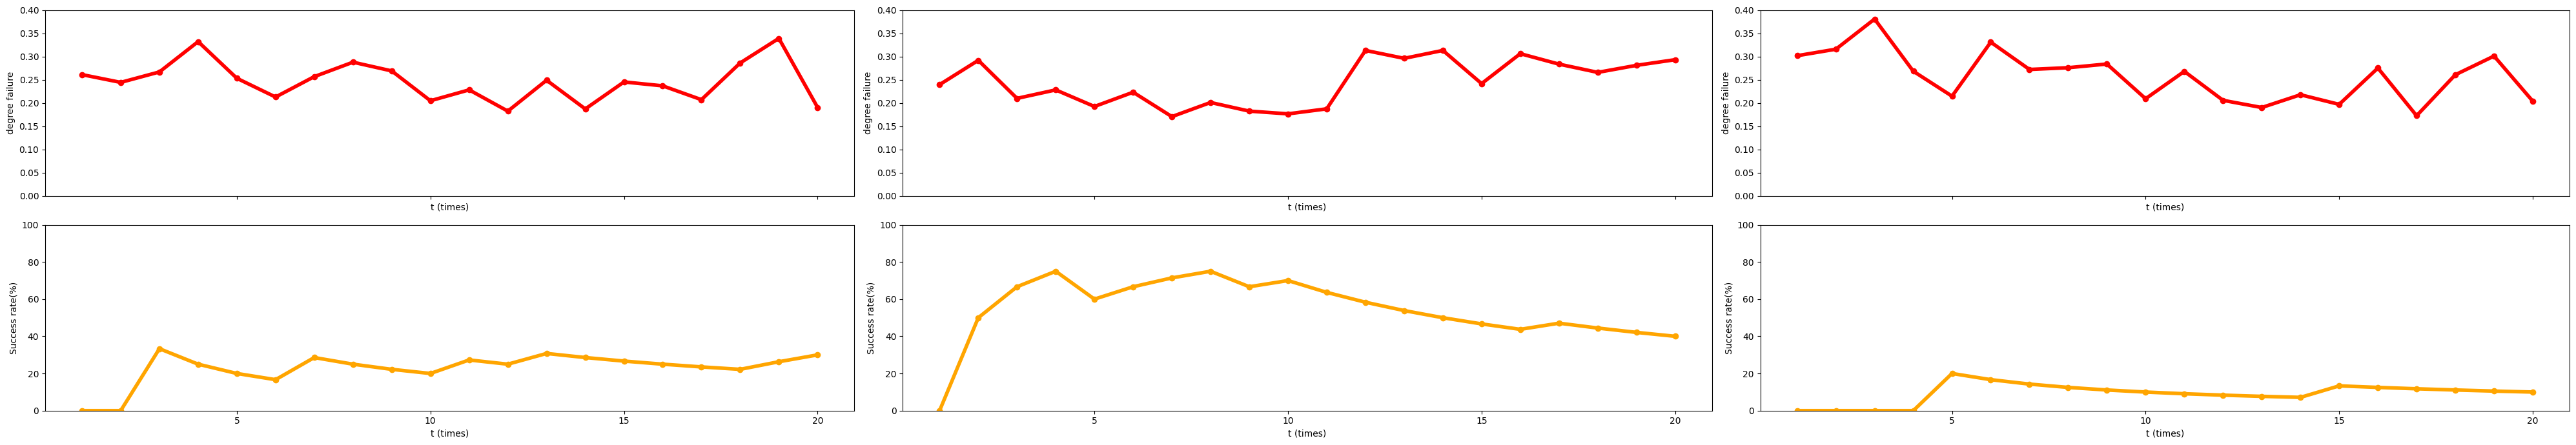

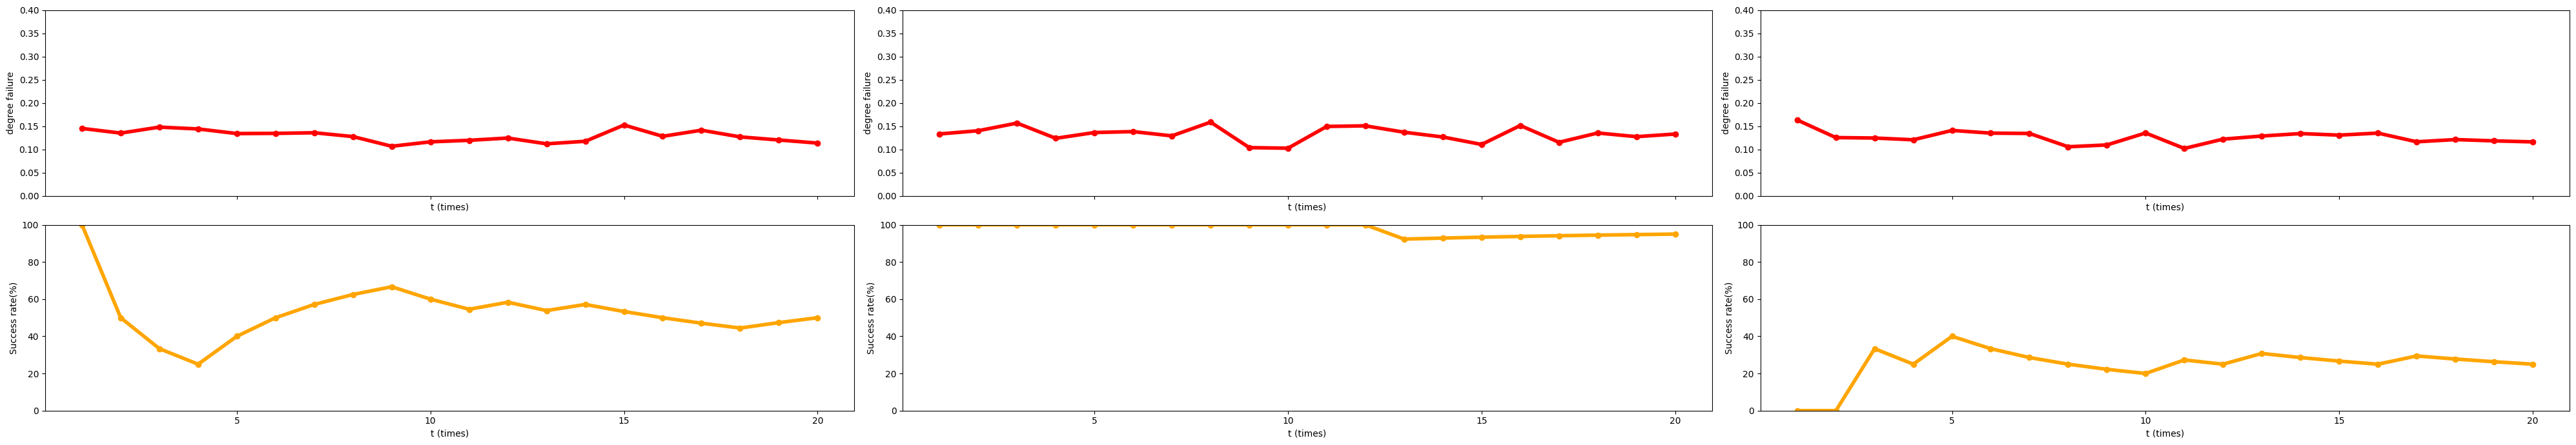

In [64]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 0
difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = inamura_data_show.make_result(difficulty_levels, division, "default")
column = 2
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 0)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 3)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 6)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 9)

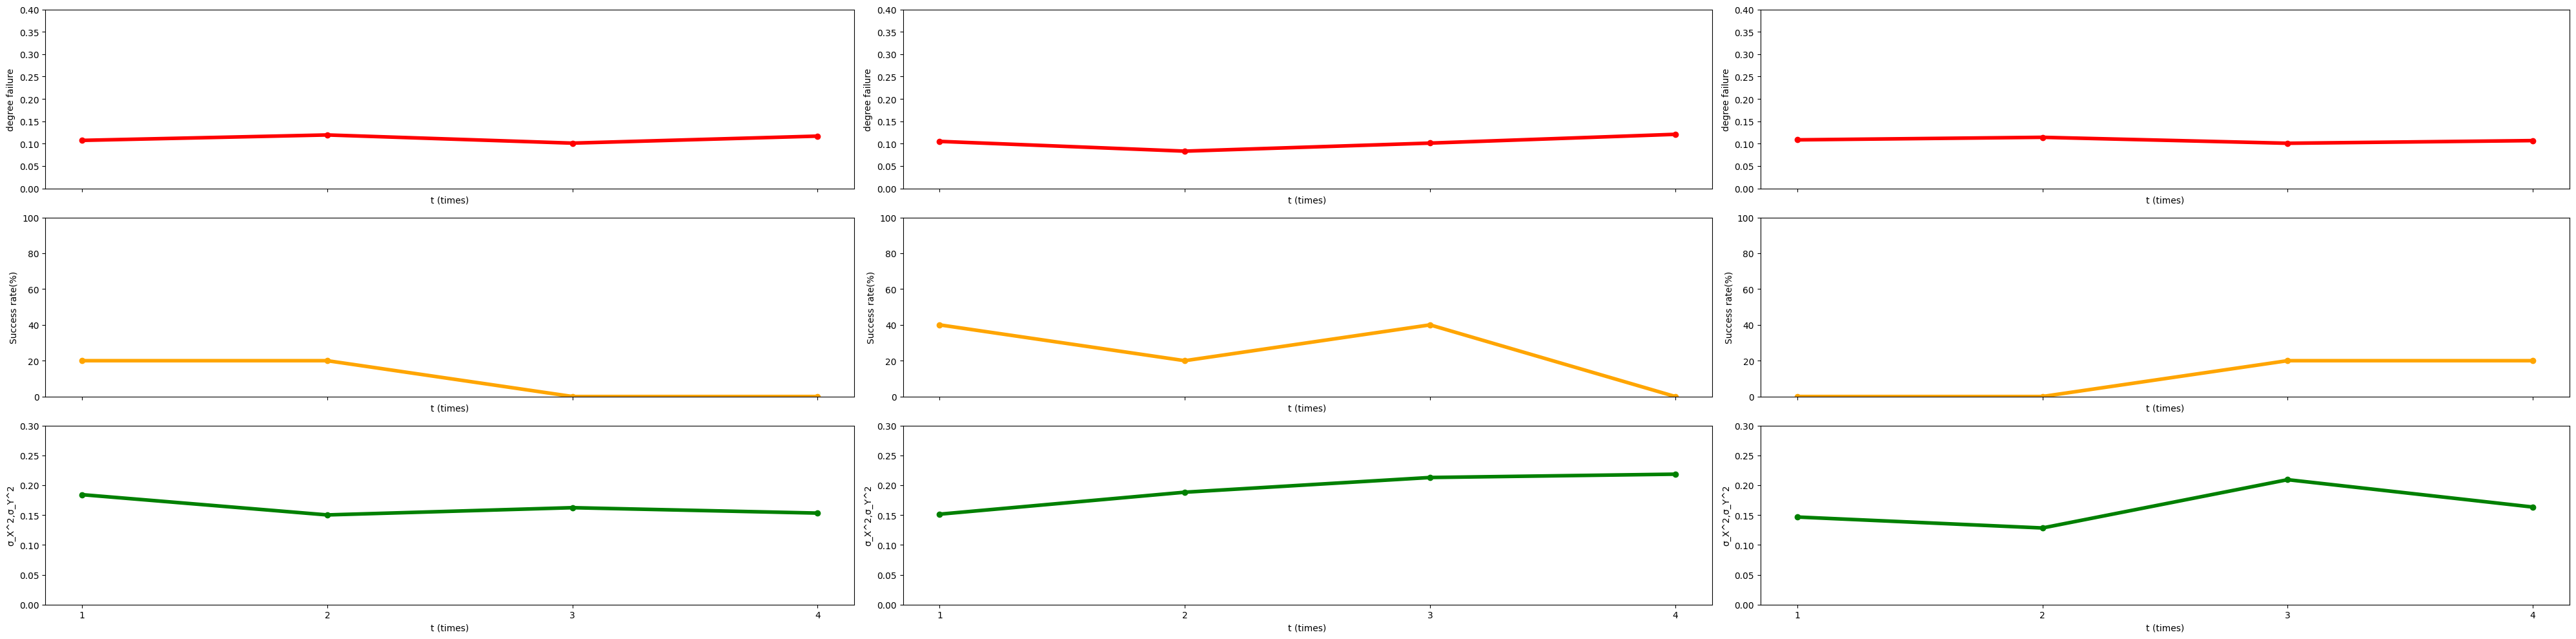

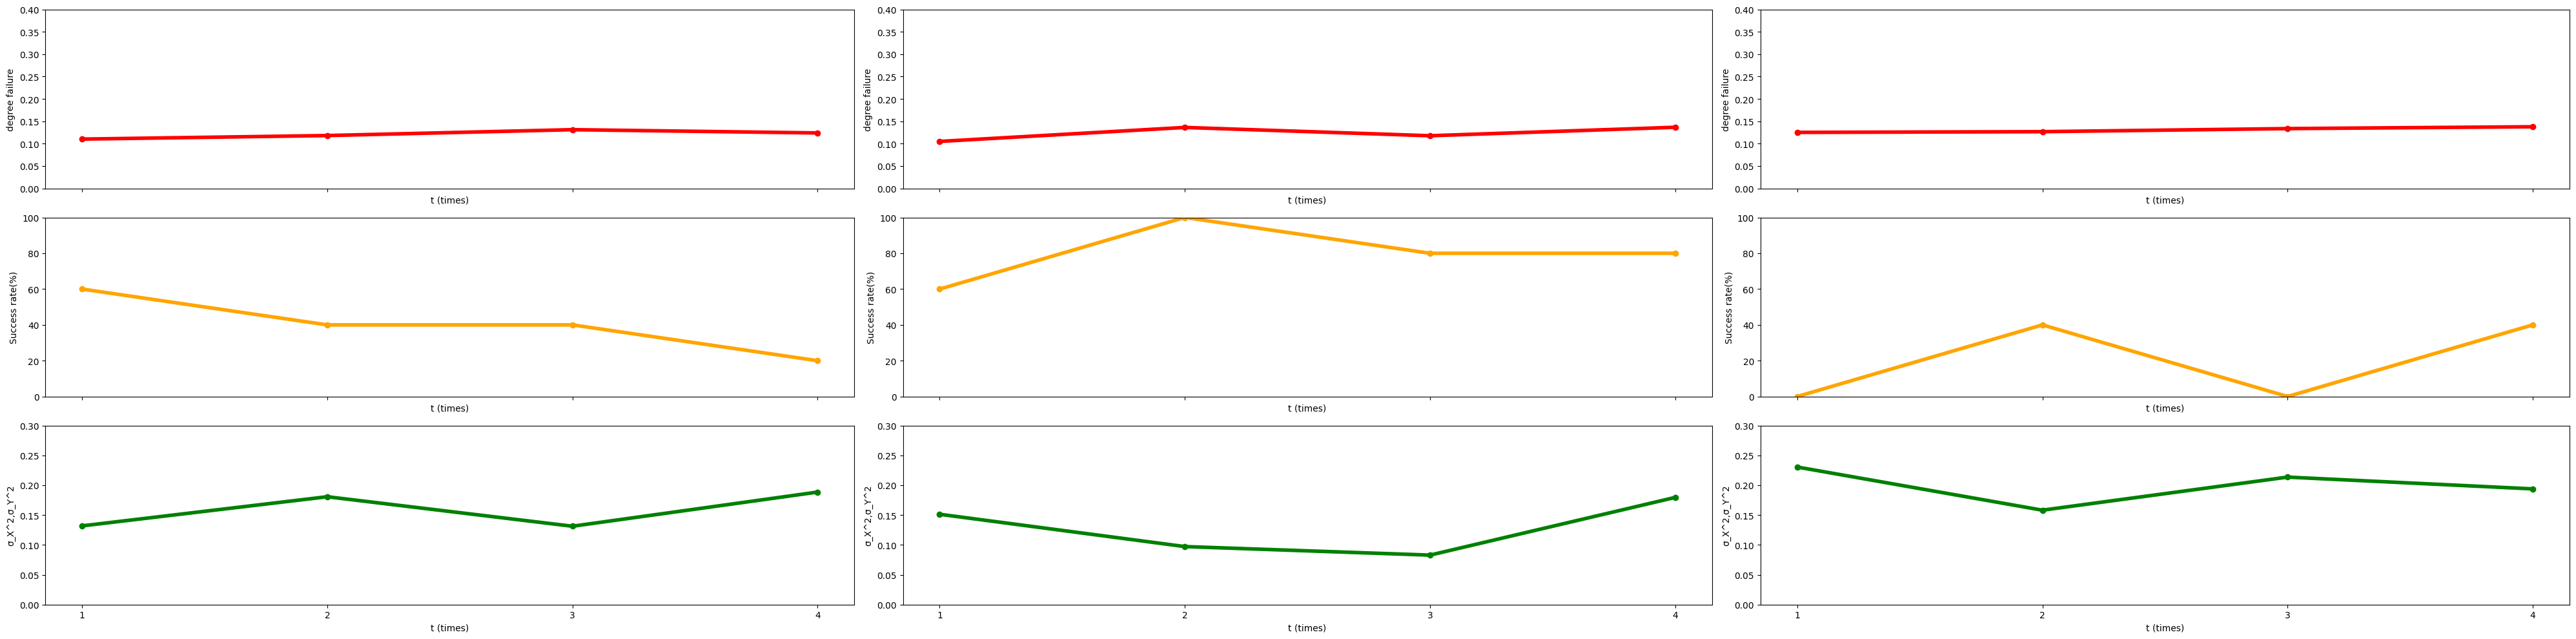

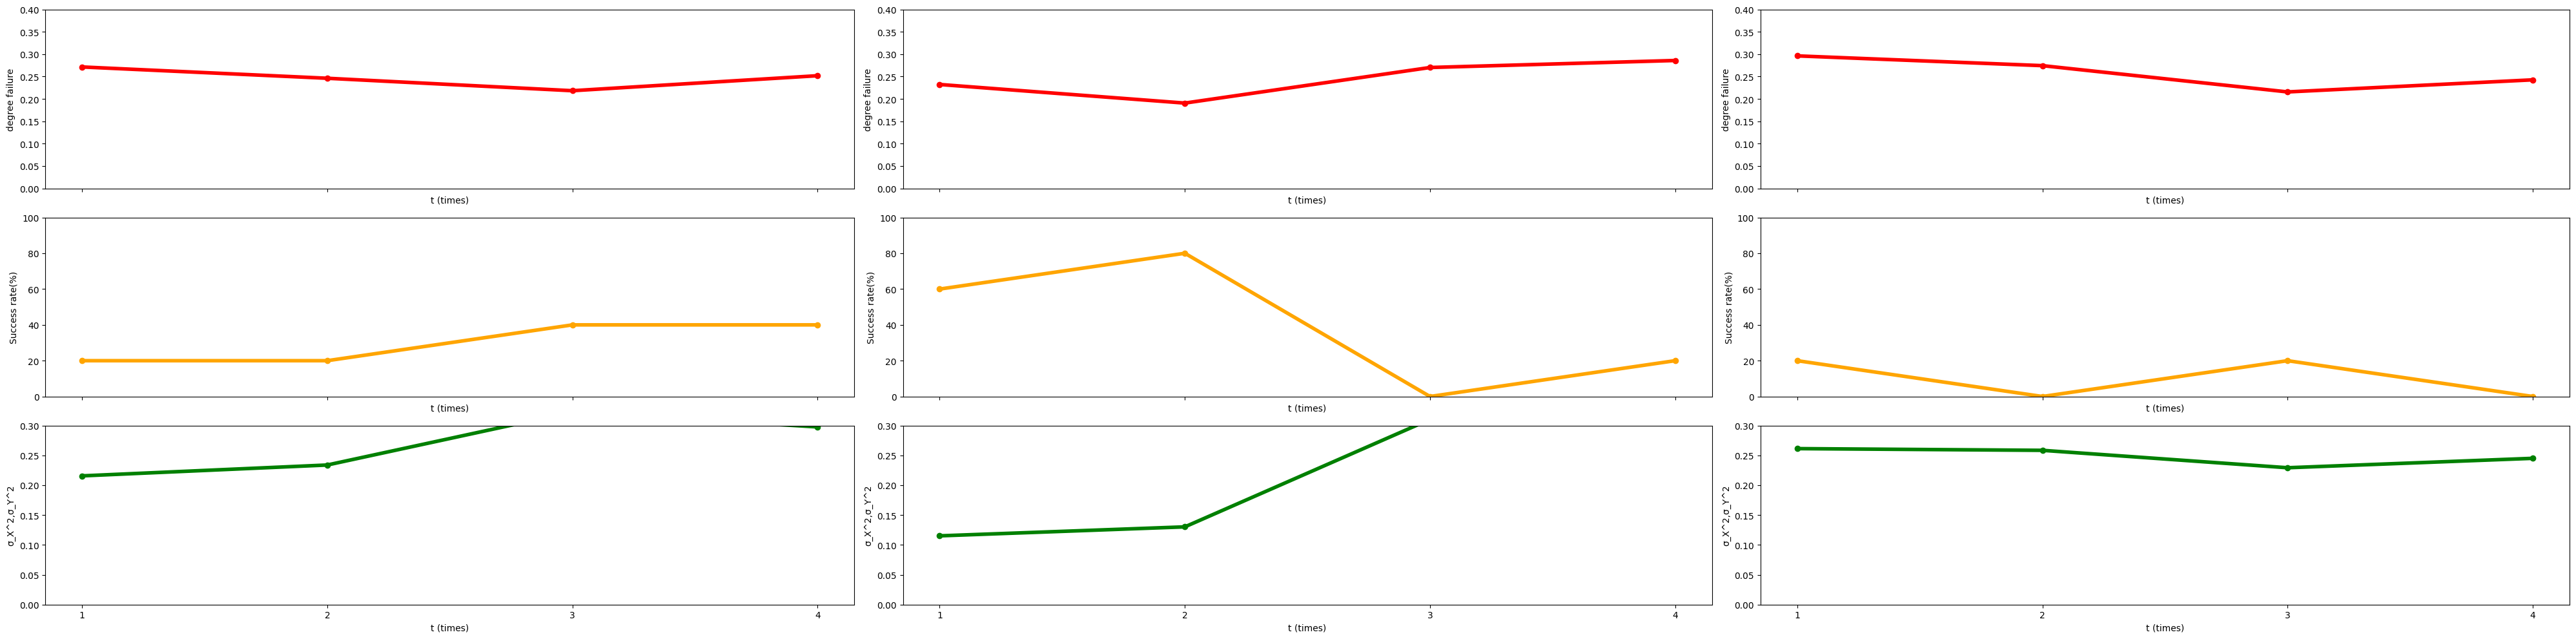

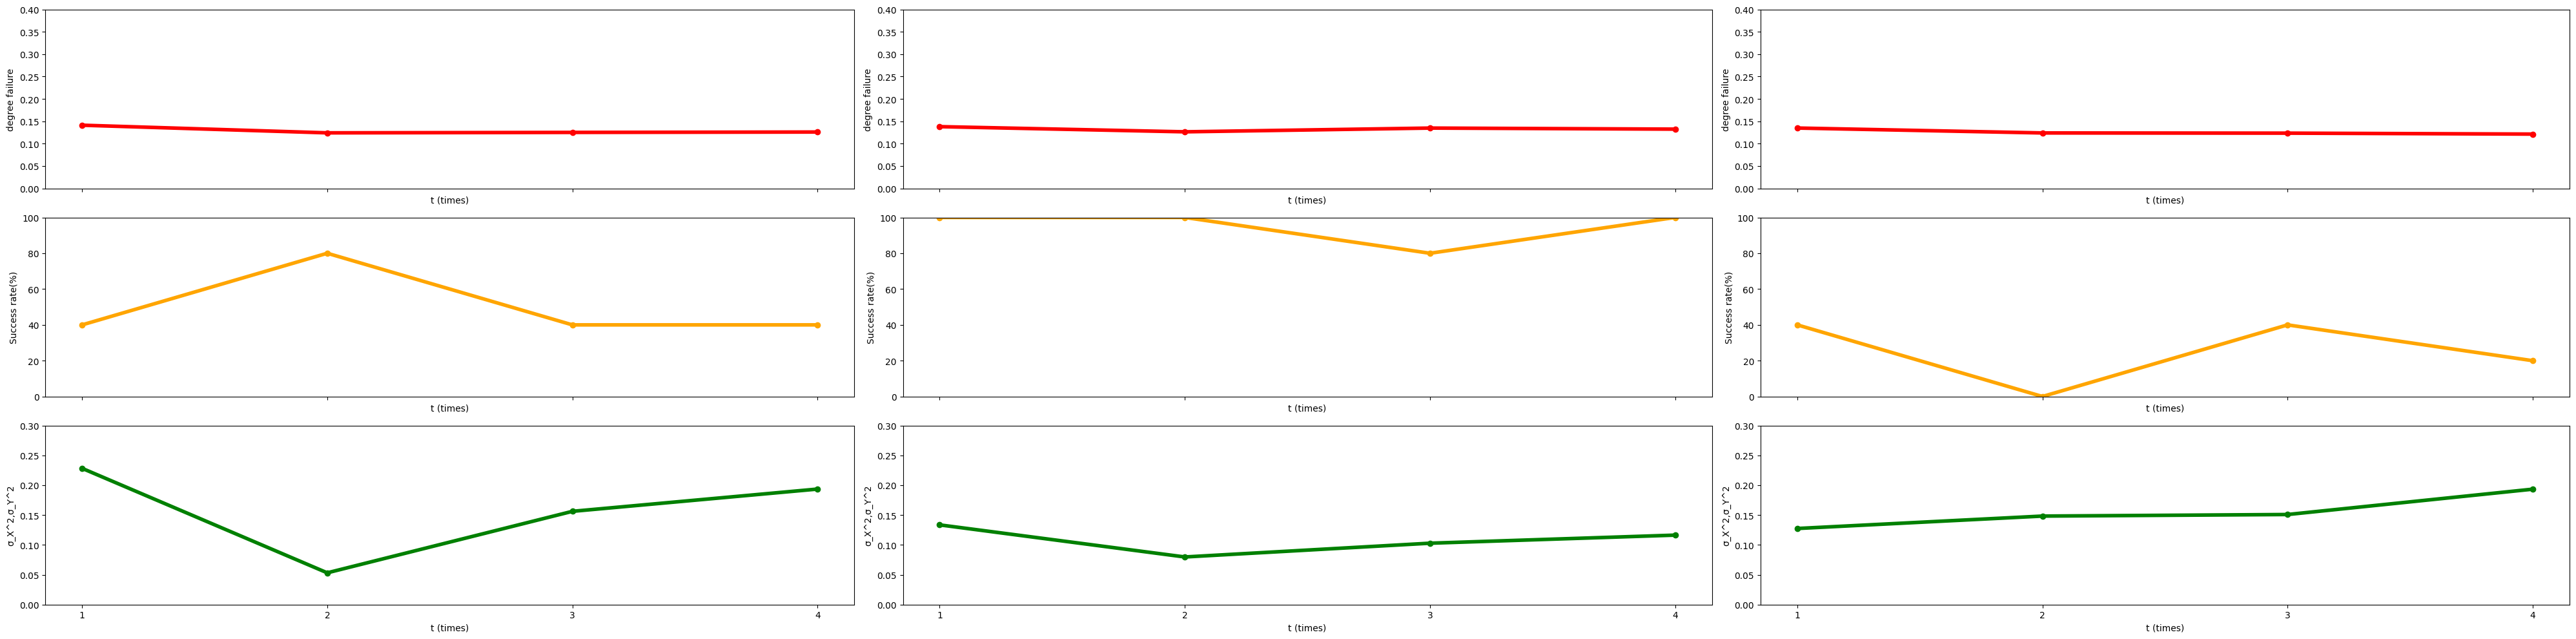

In [65]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
width = 0
division = 5
A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = inamura_data_show.make_result(difficulty_levels, division, "default")
column = 3
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 0)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 3)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 6)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 9)

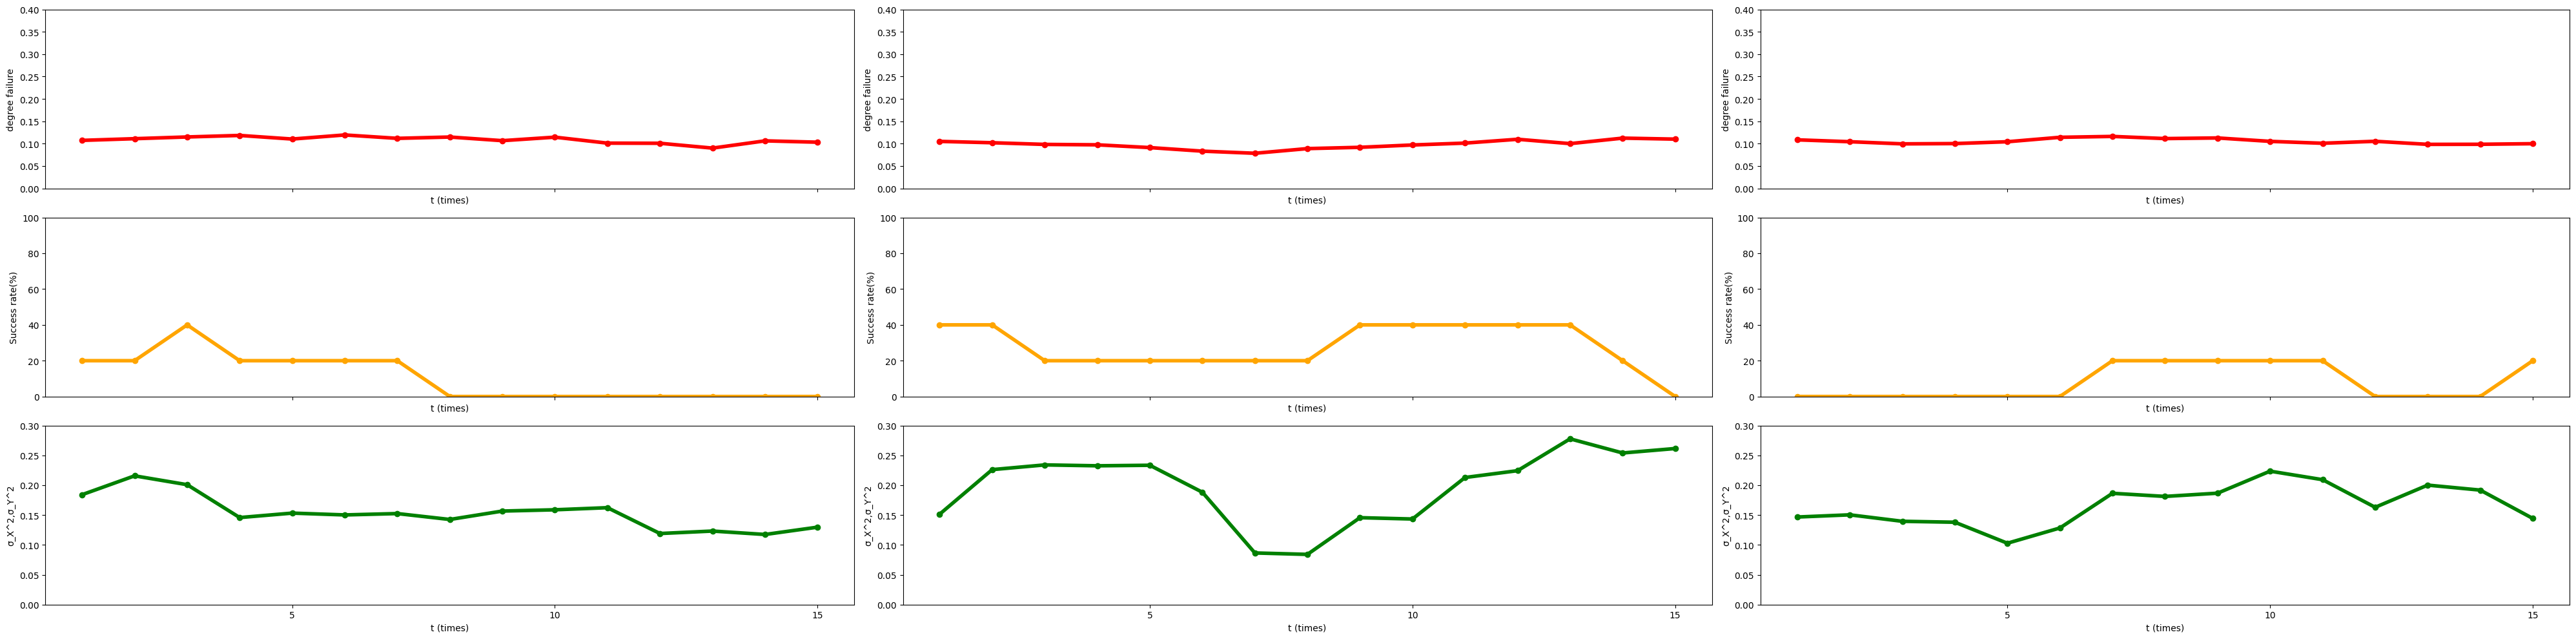

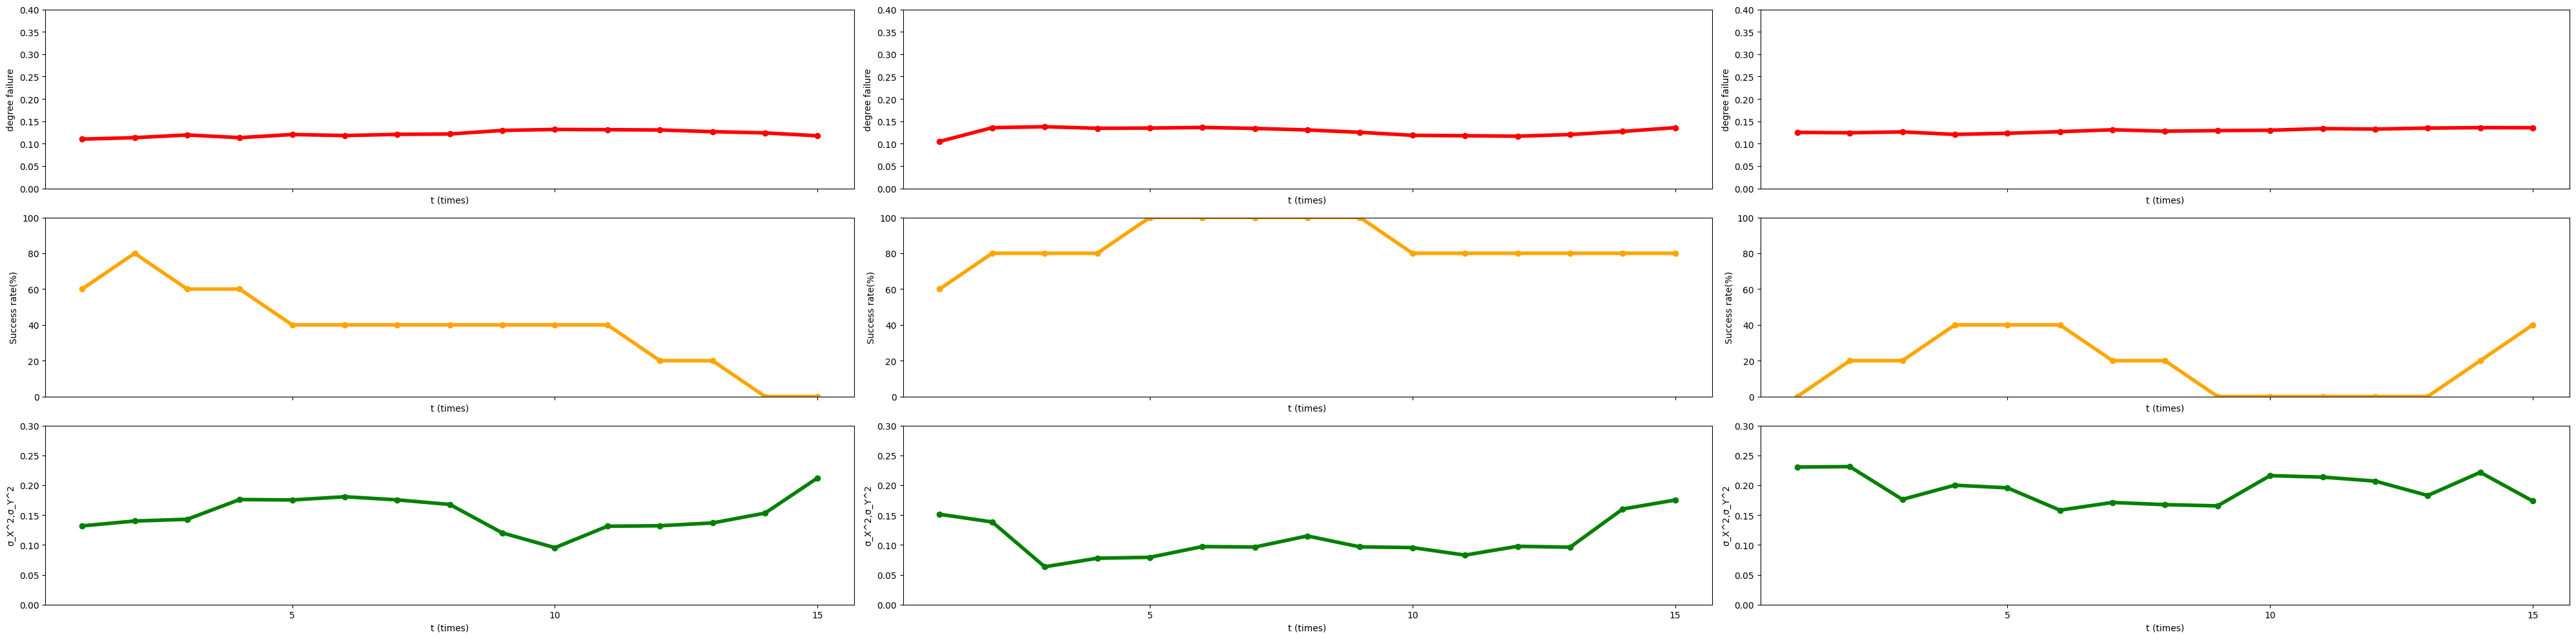

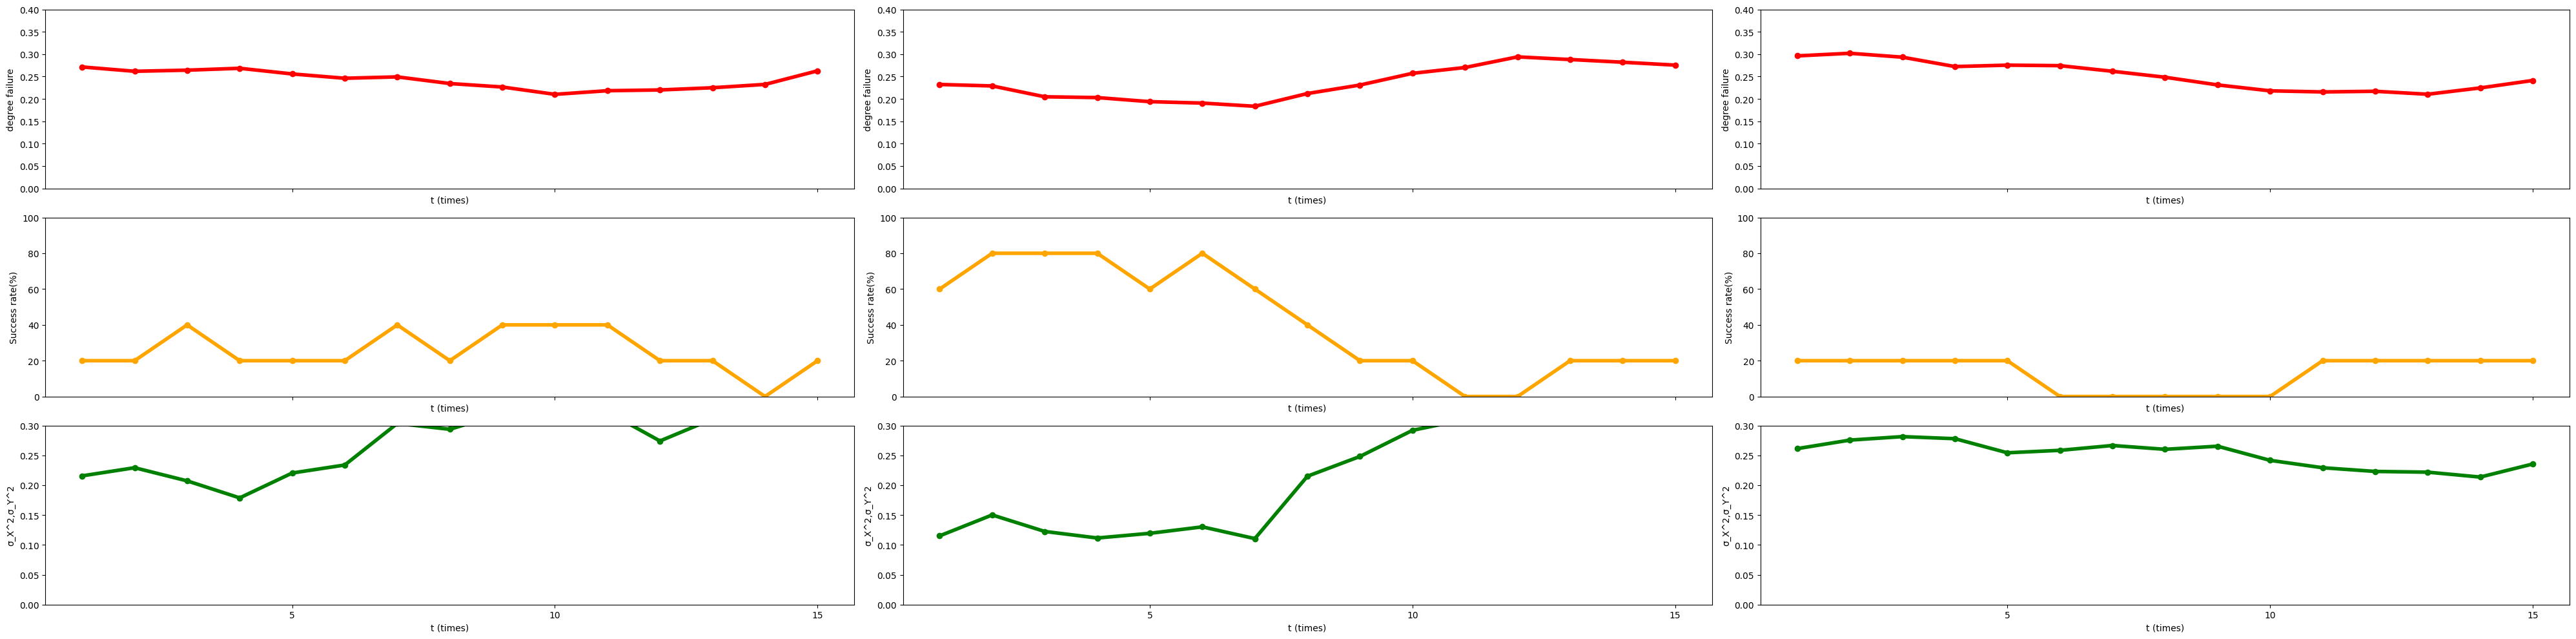

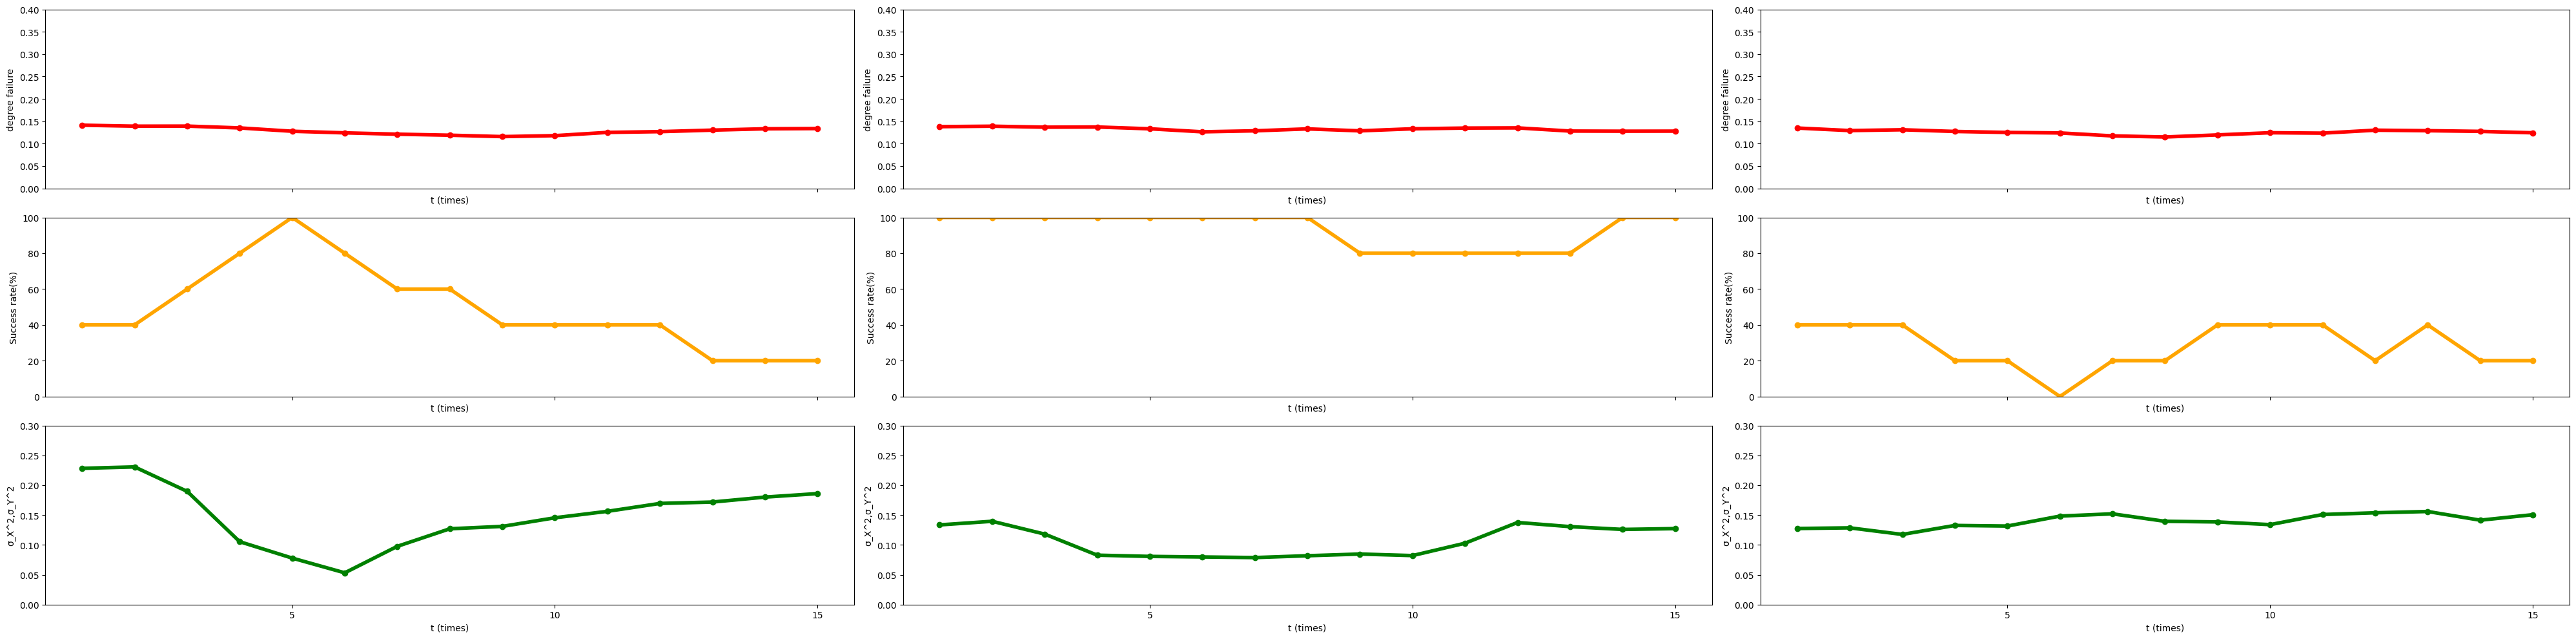

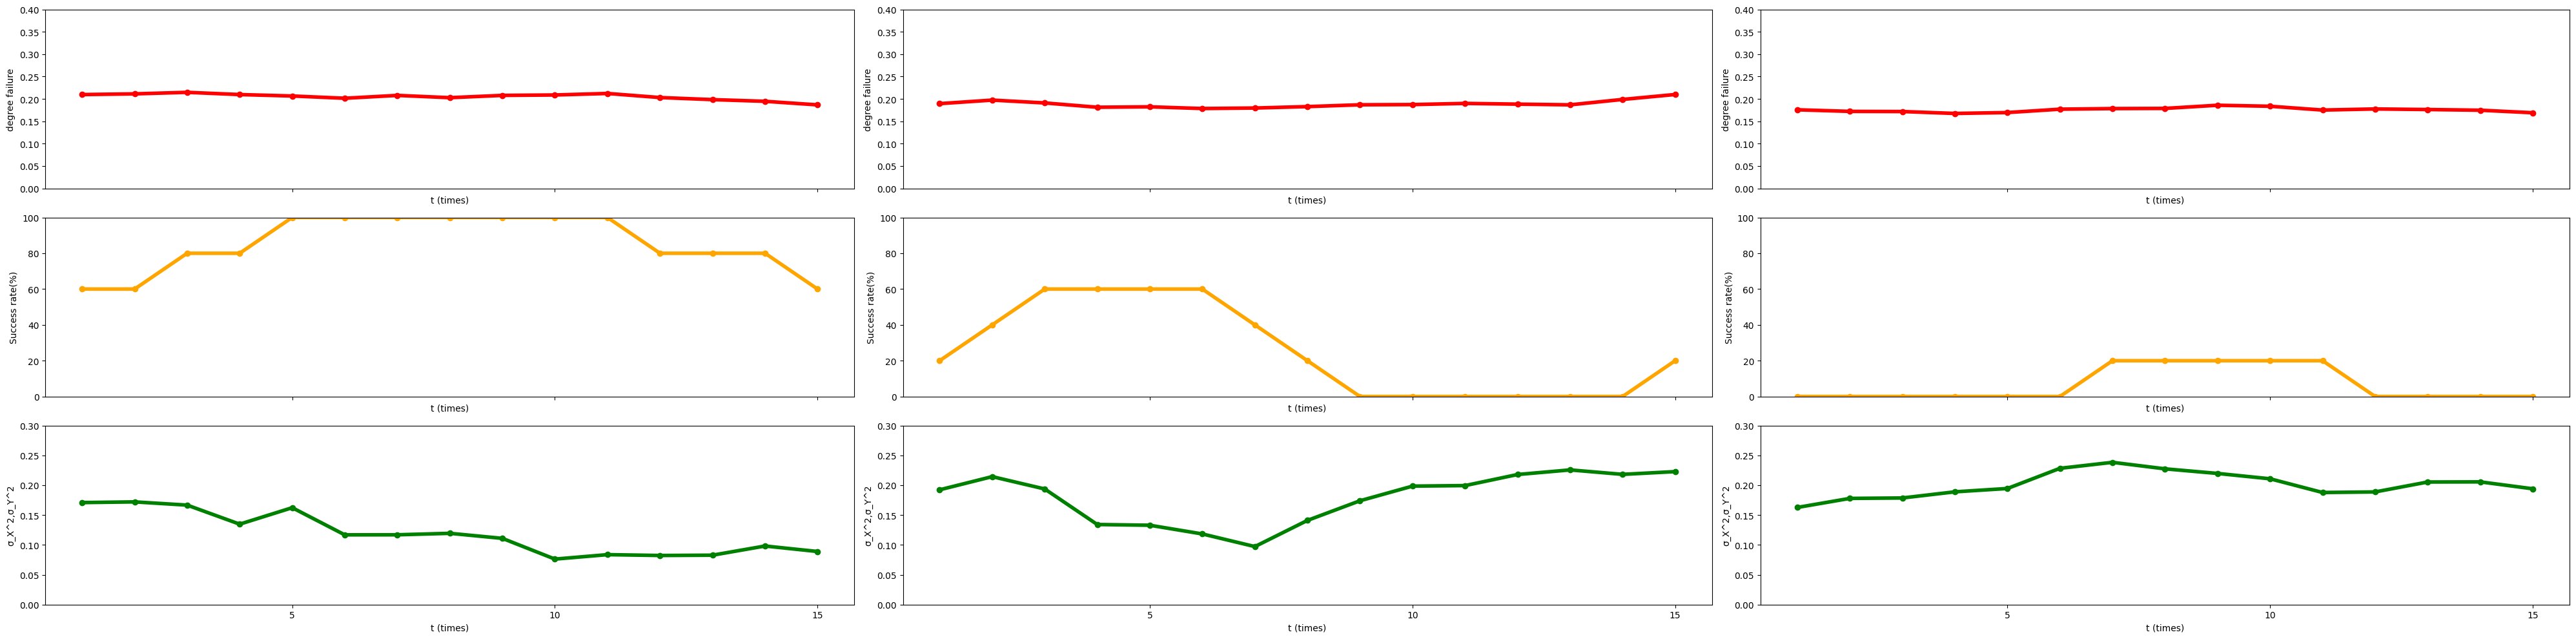

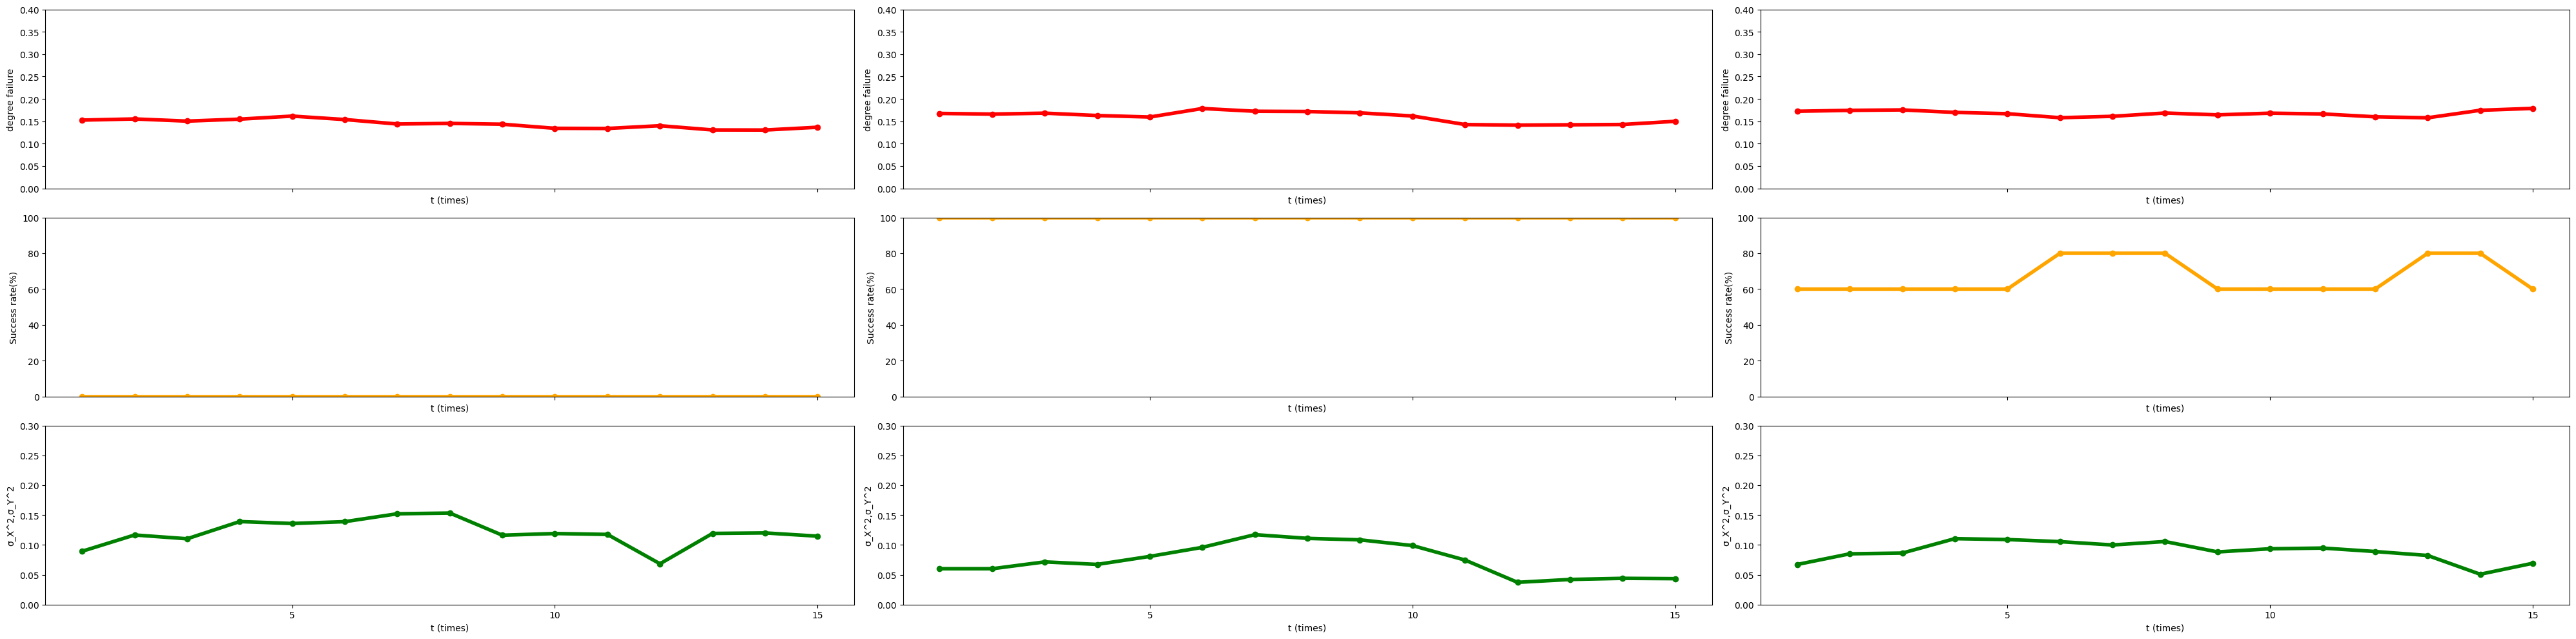

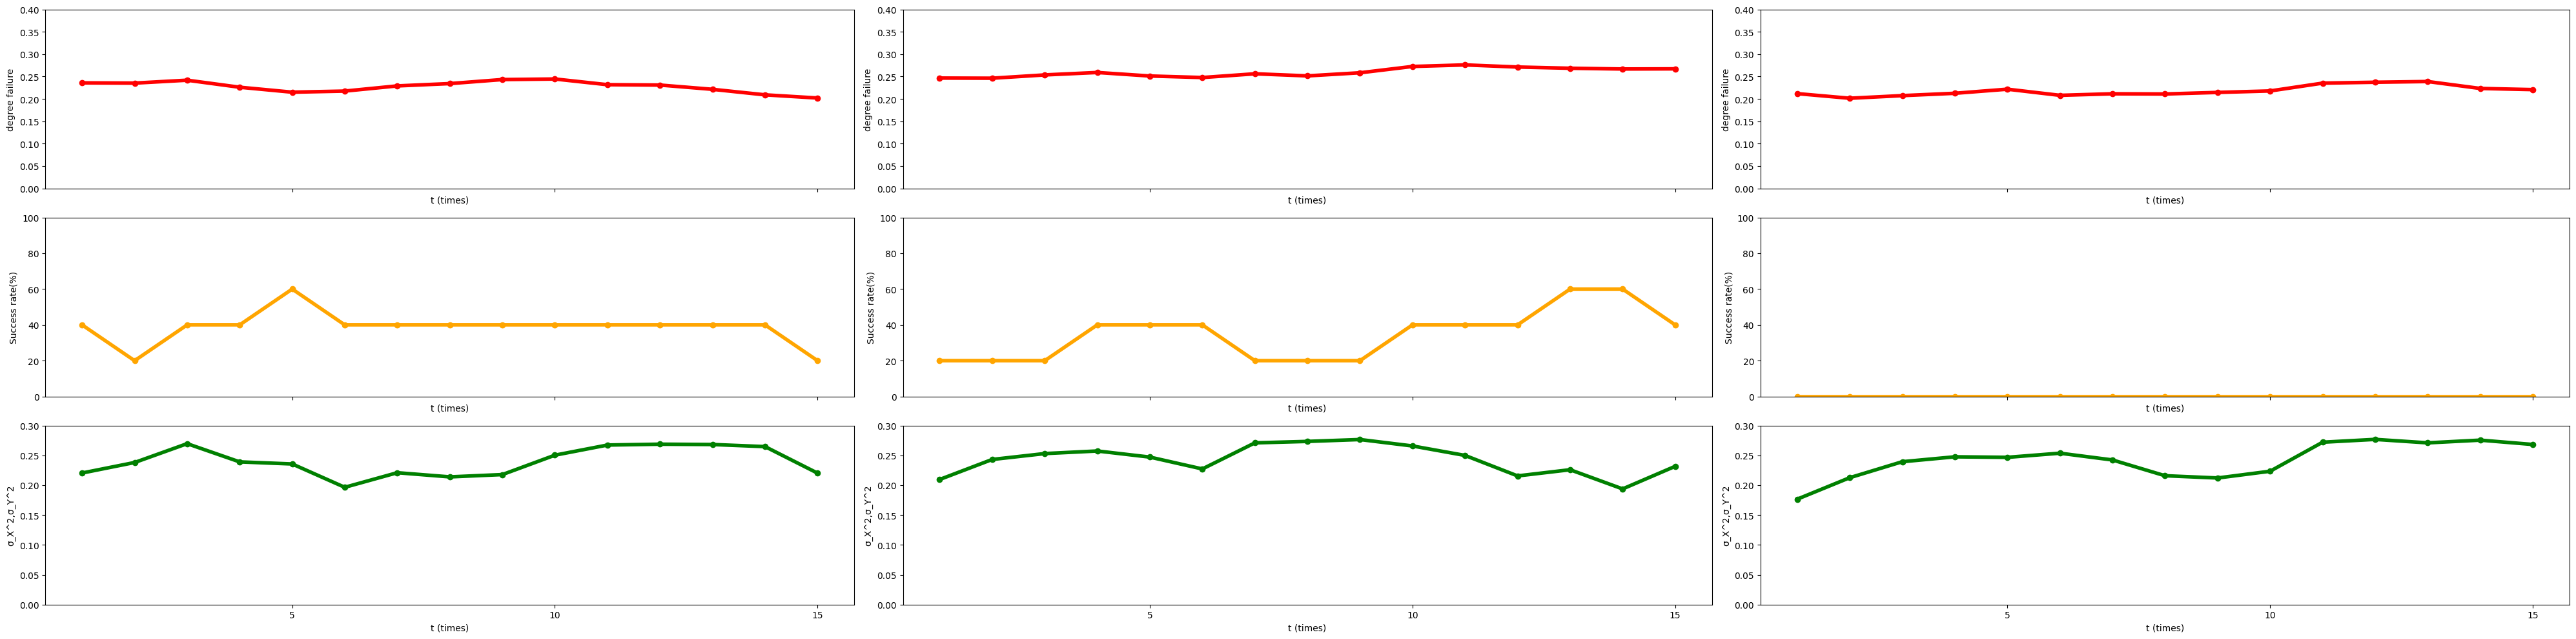

In [66]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 5
A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = inamura_data_show.make_result(difficulty_levels ,division, "divided", width)
column = 3
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 0)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 3)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 6)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 9)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 12)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 15)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 18)

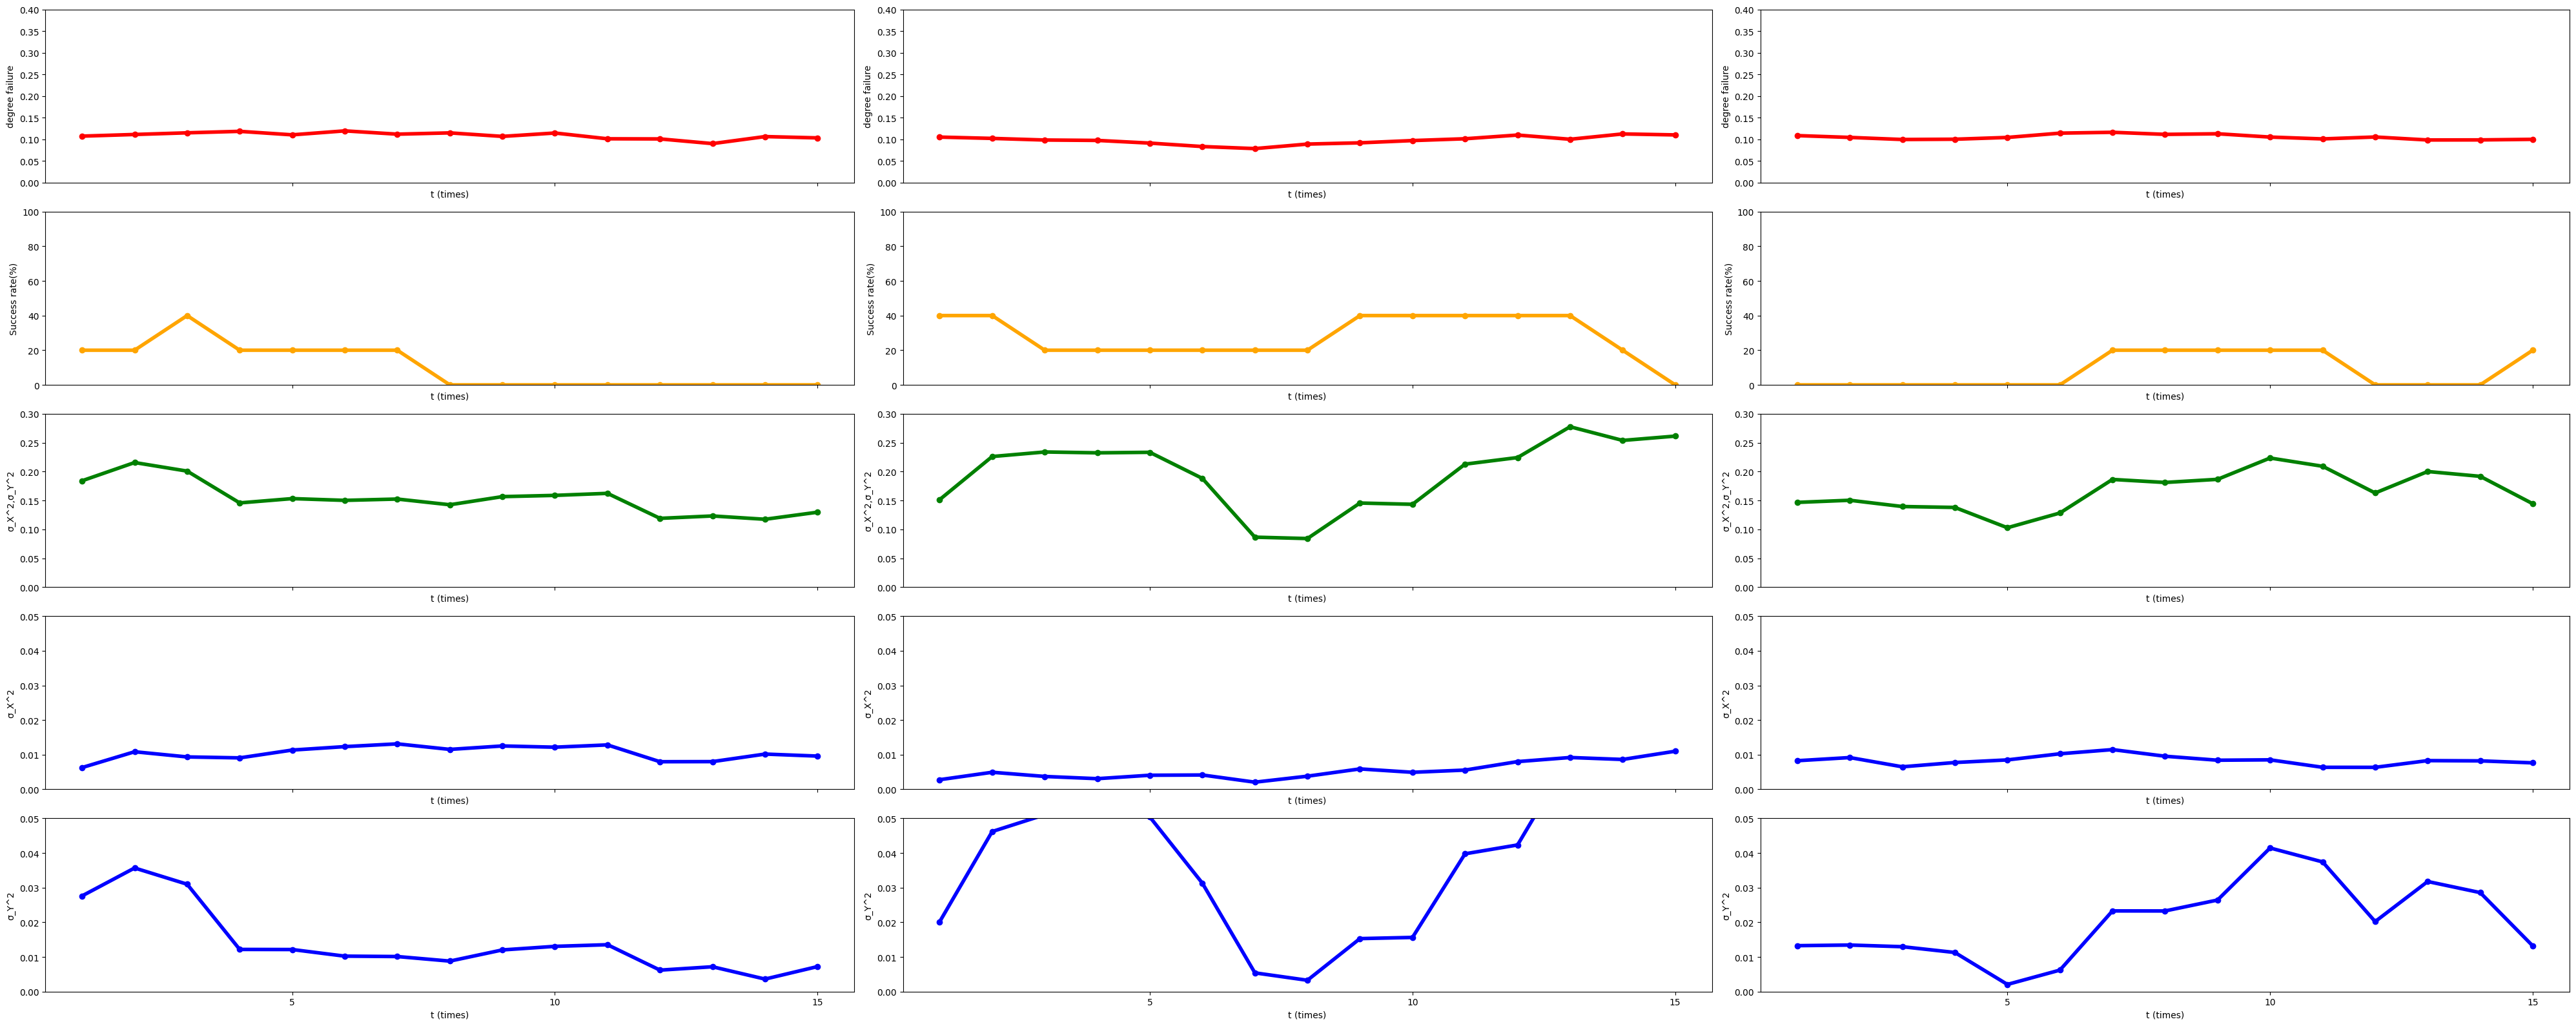

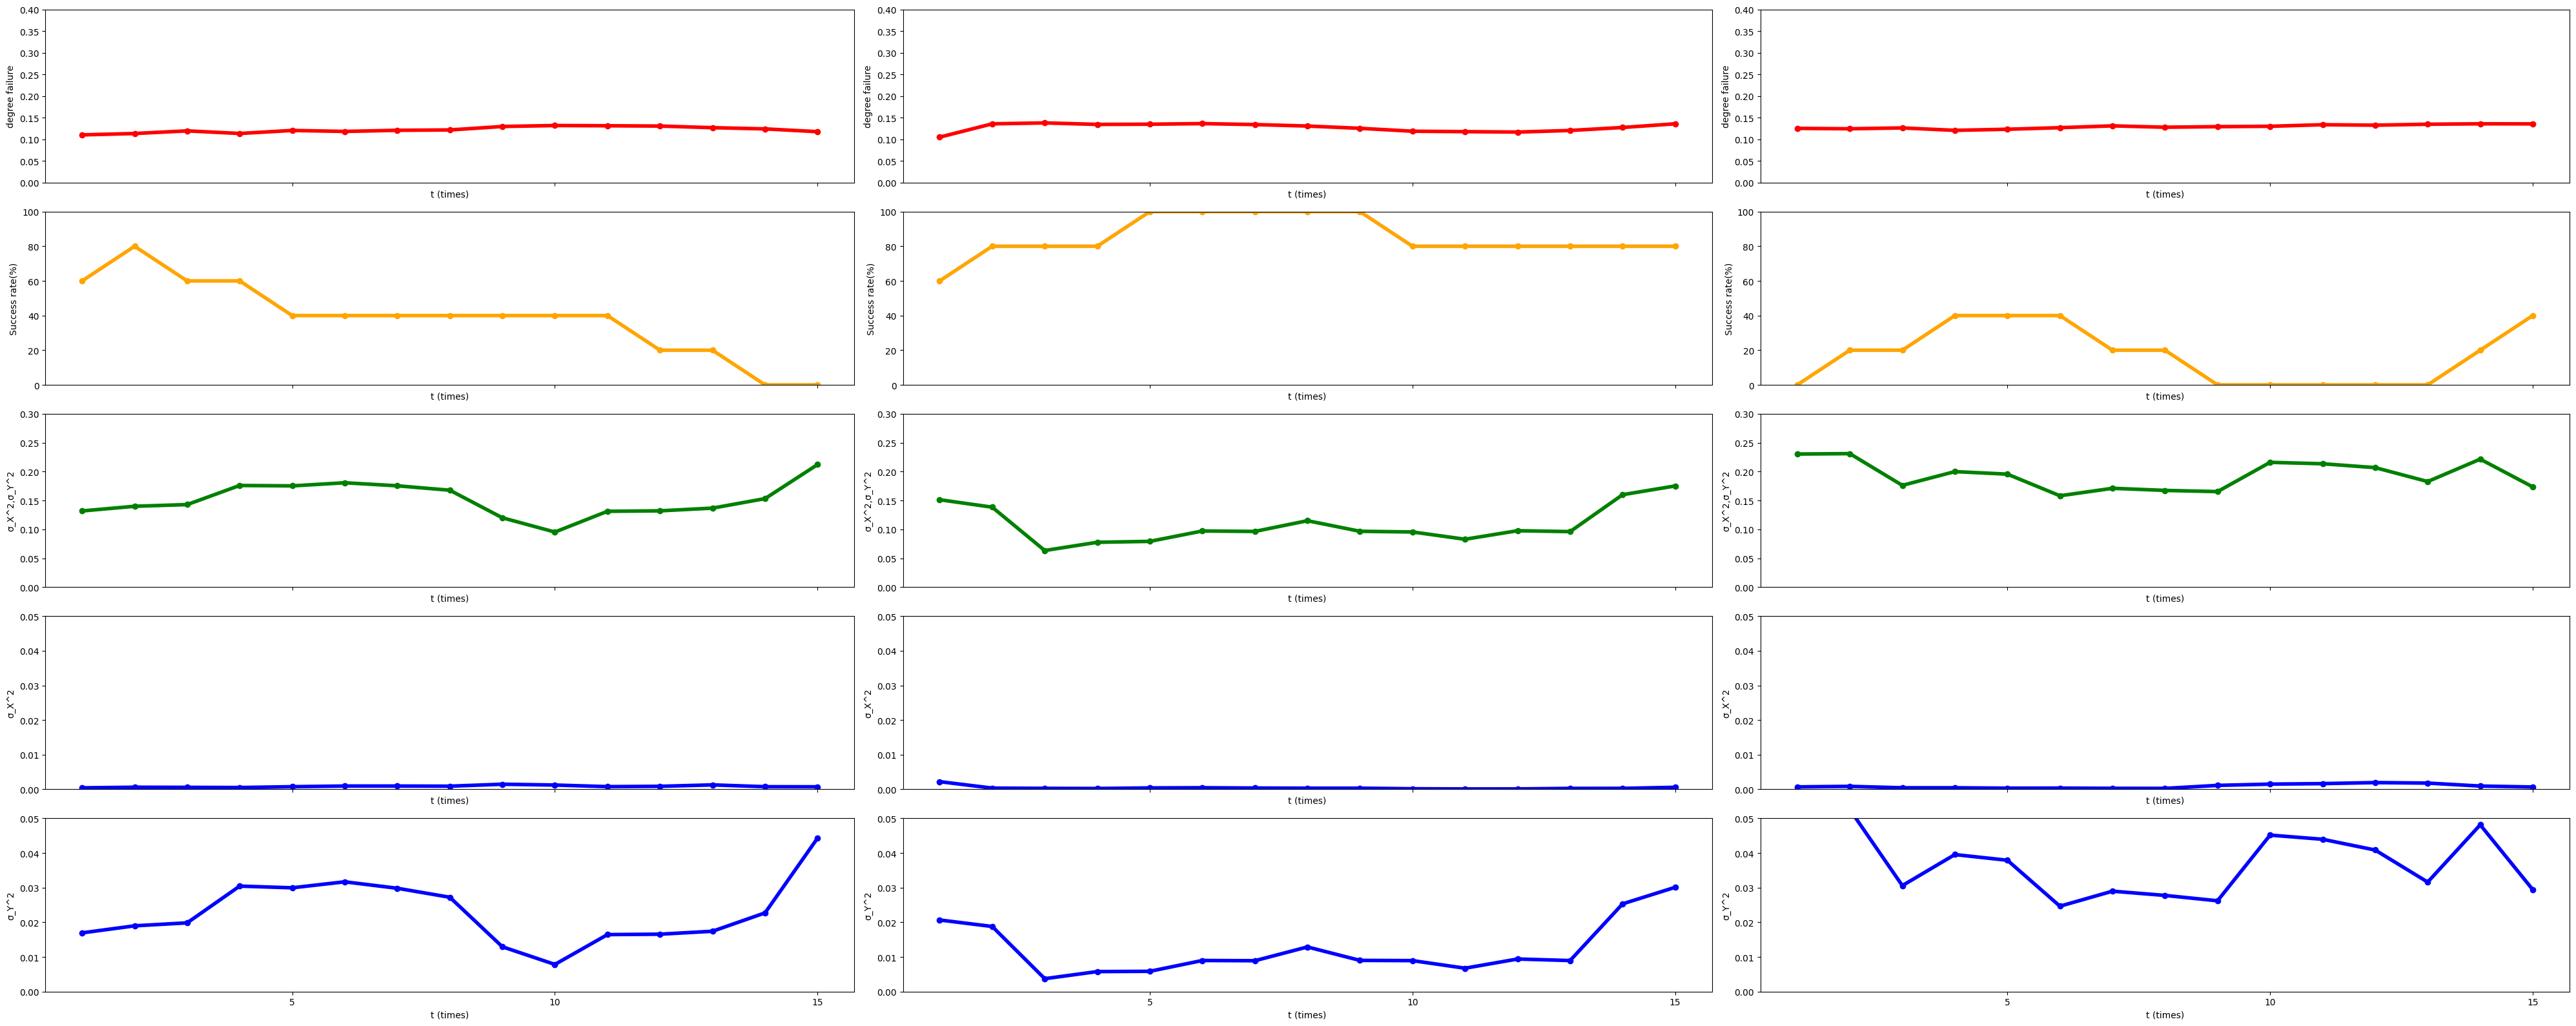

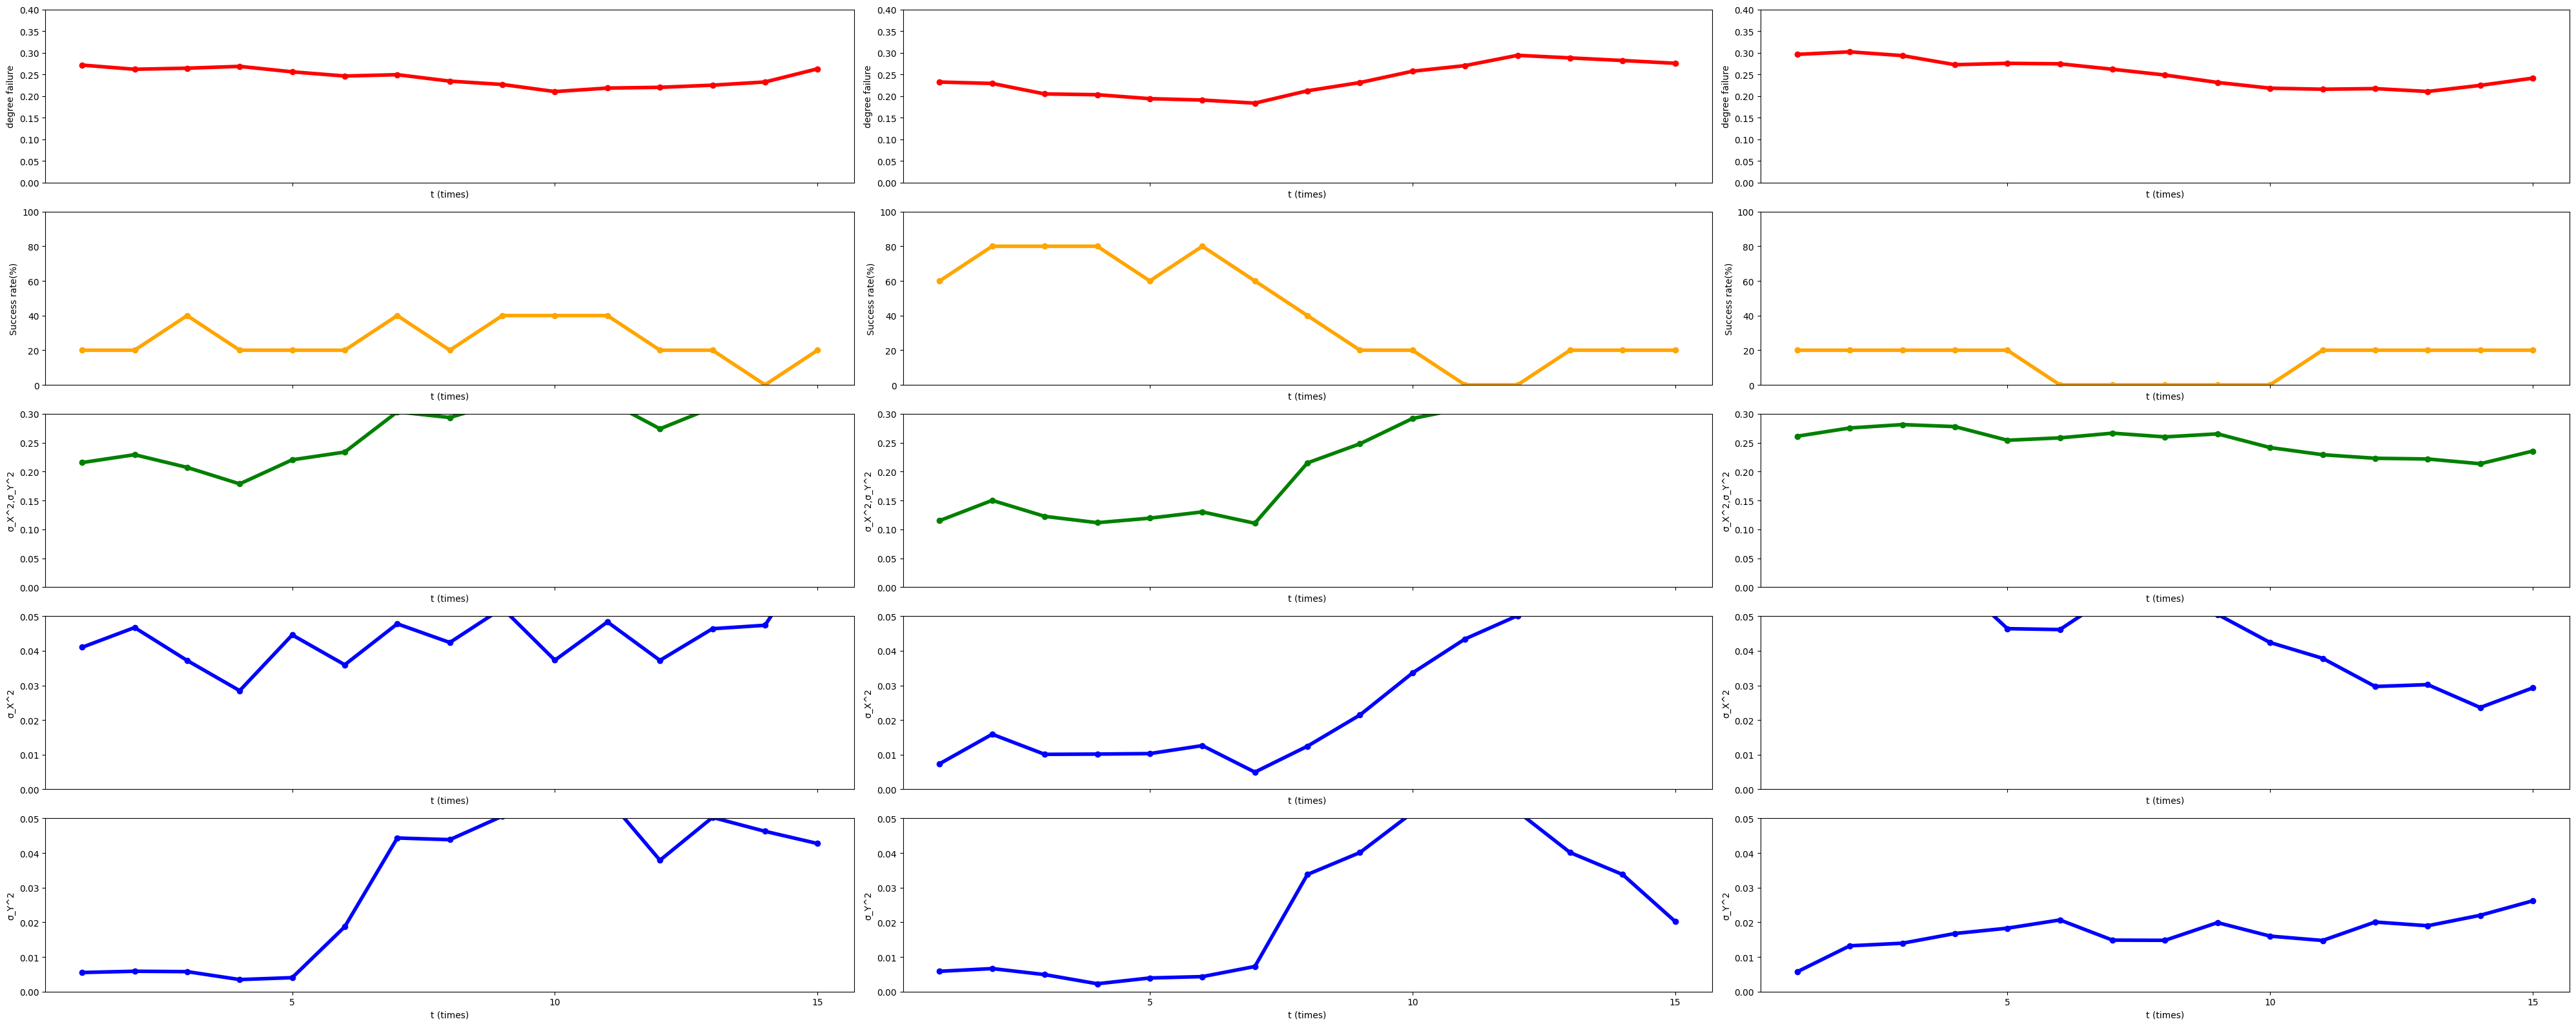

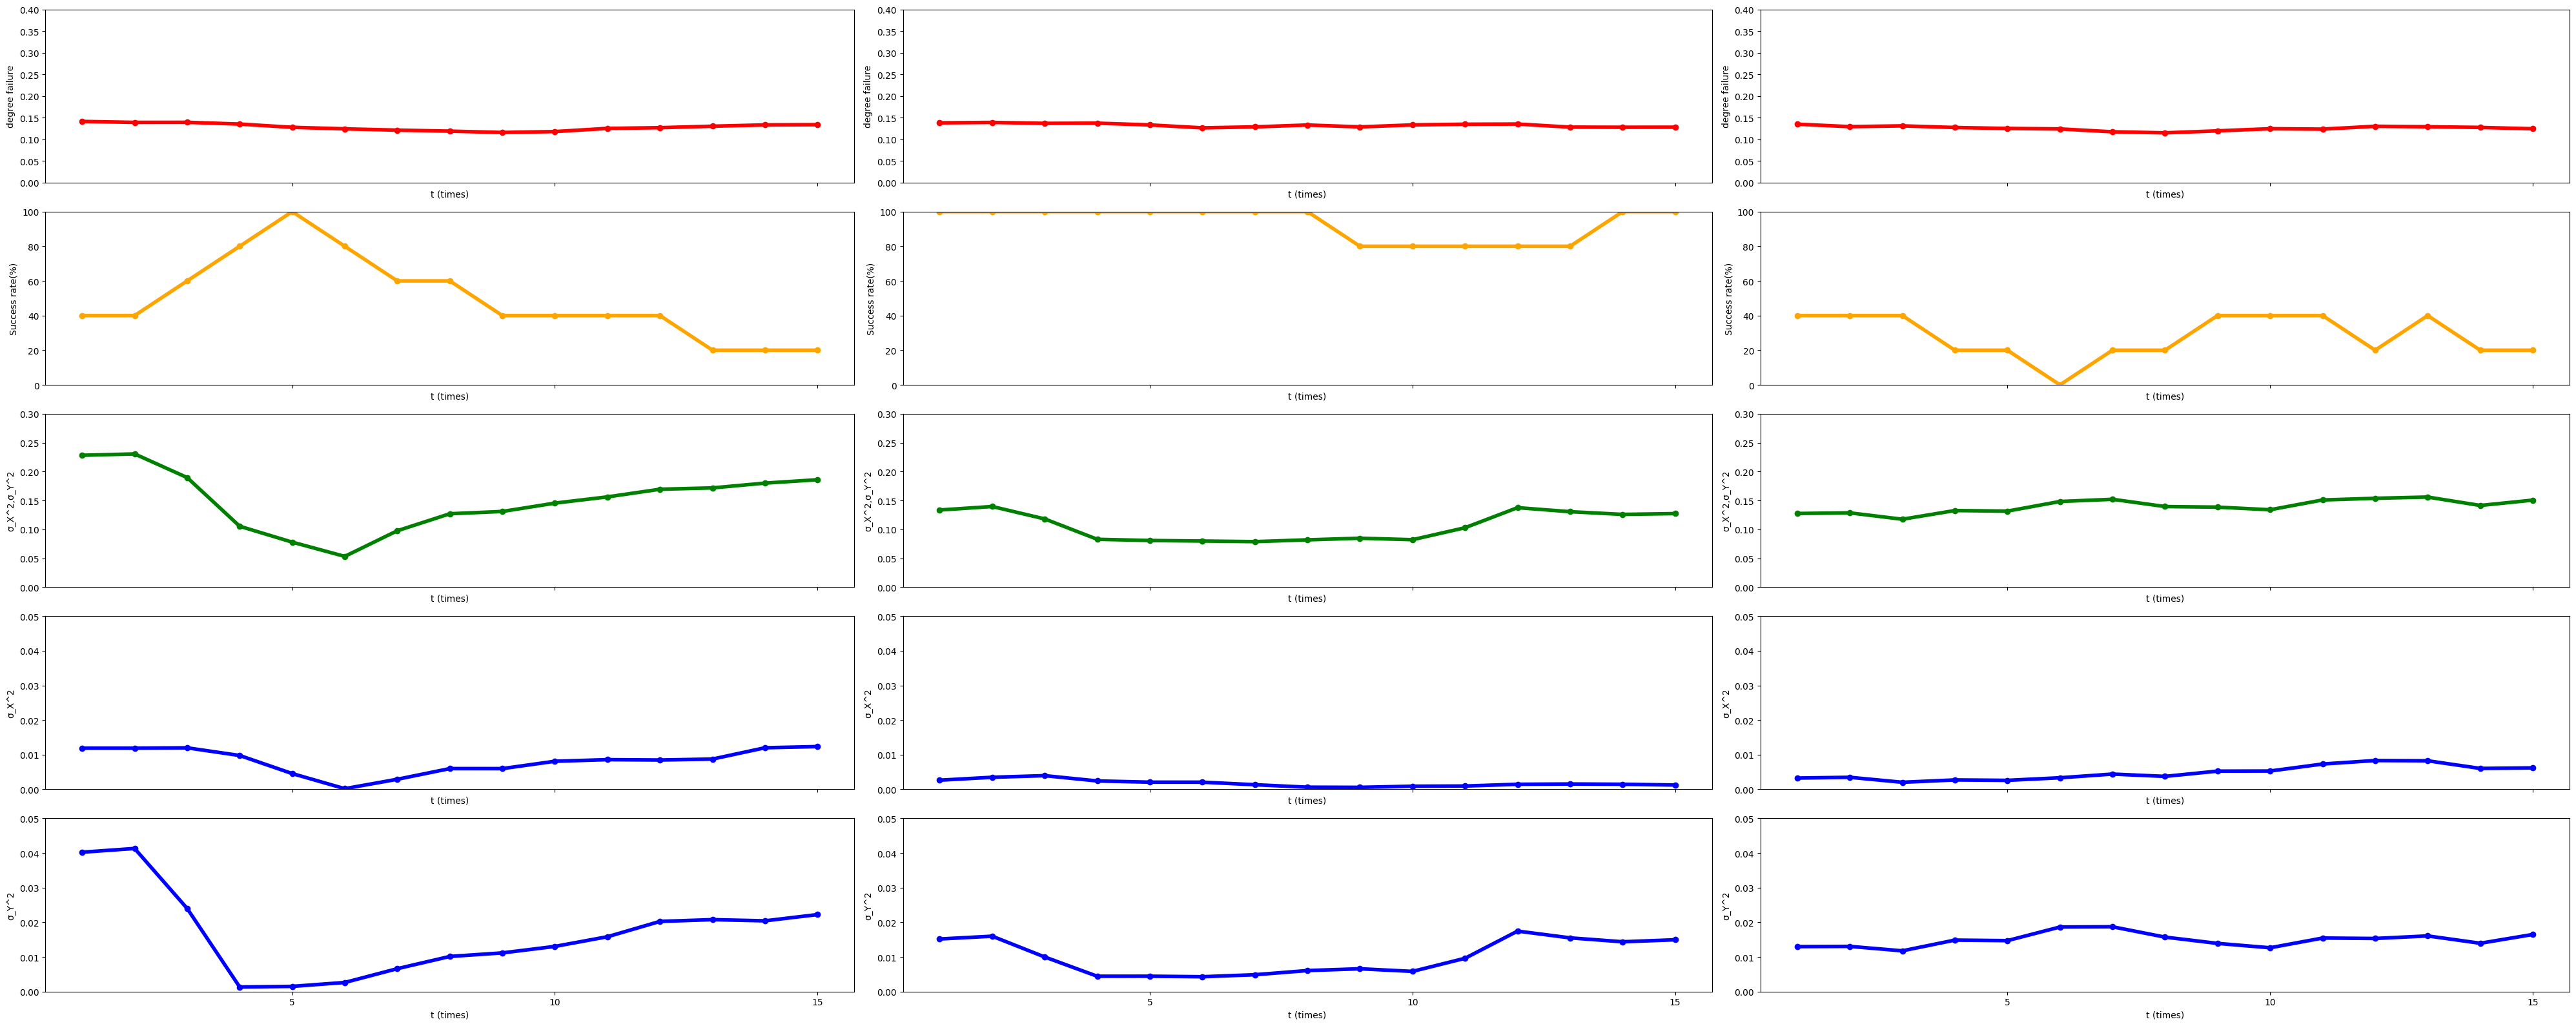

In [67]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 5
A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = inamura_data_show.make_result(difficulty_levels, division, "divided", width)
column = 5
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 0)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 3)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 6)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 9)

ここ以降は、グラフデータを辞書形式で管理してみたコード

In [ ]:
class Kendama_analyze():
  def __init__(self, original_pattern, number_people):
    self.original_pattern = original_pattern #ファイルのリンクを格納
    self.number_people = number_people #どれだけのデータ数を使用するかを決定する変数

  #被験者一人の解析を行う関数
  def start_analyze(self, Kendama_file_path,division, pattern):
    #成功した時と失敗した時の処理を行うコード
    dispersion = np.empty((0,2))     #被験者のやる気を表す分散を格納する配列
    Abs_degree_failure = np.array([])
    x = np.array([])  #試行回数を格納
    success = 0
    srate = np.array([])
    succ_check = True
    abs_degree_failure_sum = 0
    variance_x_sum = 0
    variance_y_sum = 0
    success_sum = 0
    abs_degree_failure = 0
    variance_x = 0.01
    variance_y = 0.01
    #他の初期値の宣言を書く（abs_degree_failureなど）
    for i in range(len(Kendama_file_path)):
      data_check = True #dataが正しいのかのチェックを行う。もし、おかしければ１つ前の施工データを使用するようにする
      if "fail" in Kendama_file_path[i]:
        succ_check = False
      else:
        succ_check = True
      df=pd.read_csv(Kendama_file_path[i],engine='python') #CSVファイルのパスを指定

      for index, row in df.iterrows(): #1行目から順番に内容を取得している処理
        if i == 0:
          p = np.array([[row['sword.Position.x'],row['sword.Position.y']]]) #皿のガウス分布の平均値を格納する配列
        if succ_check: #成功した時
          if abs(row['ball.Position.y'] - row['sword.Position.y']) <= 0.05: #玉がplateに乗っているもしくは直前かどうか
            data_check = False
            p = np.append(p, [[row['sword.Position.x'],row['sword.Position.y']]], axis = 0) #plateの原点を次回の平均値に入れる
            abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
            abs_degree_failure_sum += abs_degree_failure
            variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y = (row['sword.Position.y']-p[i][1])**2
            variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y_sum += variance_y
            success_sum += 1
            # sigma = sigma/alpha
            break
        else: #失敗した時
          if abs(row['ball.Position.y'] - row['sword.Position.y']) <= 0.1: #玉がplateに乗っているもしくは直前かどうか
            data_check = False
            p = np.append(p, [[row['ball.Position.x'],row['ball.Position.y']]], axis = 0) #玉の落下位置を次回の平均値に入れる
            abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
            abs_degree_failure_sum += abs_degree_failure
            variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y = (row['sword.Position.y']-p[i][1])**2 #このコードは分散とは言えない
            variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
            variance_y_sum += variance_y
            # sigma = sigma*beta
            break
      if data_check: #dataに何らかの不備があった場合の応急処置のコード
        p = np.append(p, [p[i]], axis = 0)
        abs_degree_failure_sum += abs_degree_failure
        variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
        variance_y_sum += variance_y

      if (i+1)%division == 0: #divisionによっていくつごとに平均を取るか決まる
        dispersion = np.append(dispersion, [[variance_x_sum/division,variance_y_sum/division]], axis=0)
        Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure_sum/division)
        abs_degree_failure_sum = 0
        variance_x_sum = 0
        variance_y_sum = 0
        #divisionが１だと0％か１００％になるため例外処理を埋め込んでいる
        if division != 1 or pattern != "default":
          srate = np.append(srate, (success_sum/division)*100)
          success_sum = 0
        else:
          srate = np.append(srate, (success_sum/(i+1))*100)
        x =np.append(x, (i+1)//division)

    # x.append(len(Kendama_file_path))
    p = np.delete(p, 0, axis=0)
    return x,p,dispersion,Abs_degree_failure,srate

  #指定した幅での平均を使った解析
  def divided_analyze(self, division, width, pattern, difficulty_levels):
    data = []
    A_x_L = np.empty((0,int(20-width)))
    A_p_L = np.empty((0,20-width,2))
    A_dispersion_L = np.empty((0,int(20-width),2))
    A_Abs_degree_failure_L = np.empty((0,int(20-width)))
    A_srate_L = np.empty((0,int(20-width)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1から10までの数字でループ
      for level in difficulty_levels[f'{j}']:
        # new_number = '{:02d}'.format(i)  # 2桁の数字にフォーマット
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')  # 数字部分を置換
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path) #ファイルの順番がおかしいので並び替えを行うコード

        x,p,dispersion,Abs_degree_failure,srate = self.start_analyze(Kendama_file_path, division, pattern)

        #新しい配列に1つずつずらした5つの値の平均を入れる
        new_x = x[0:(len(x)-width)]
        new_p = np.array([np.mean(p[i:i+width, :], axis=0) for i in range(20-width)])
        new_dispersion = np.array([np.mean(dispersion[i:i+width, :], axis=0) for i in range(20-width)])
        new_Abs_degree_failure = np.array([np.mean(Abs_degree_failure[i:i+width]) for i in range(20-width)])
        #確率は要修正（divisionが１の場合累計の成功率になっているため）
        new_srate = np.array([np.mean(srate[i:i+width]) for i in range(20-width)])


        data.append({
                'level': level,
                'person': j,
                'x': new_x,
                'p': new_p,
                'dispersion': new_dispersion,
                'Abs_degree_failure': new_Abs_degree_failure,
                'srate': new_srate
            })
    df = pd.DataFrame(data)

    return df

  #指定した人数分解析のループを行う関数
  def loop_analyze(self, division, pattern, difficulty_levels):
    data = []
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1からnumber_peopleまでの数字でループ
      for level in difficulty_levels[f'{j}']: #fはフォーマットでjの値を入れている
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path)  # ファイルの順番を並び替え

        x, p, dispersion, Abs_degree_failure, srate = self.start_analyze(Kendama_file_path, division, pattern)

        data.append({
                'level': level,
                'person': j,
                'x': x,
                'p': p,
                'dispersion': dispersion,
                'Abs_degree_failure': Abs_degree_failure,
                'srate': srate
            })

    df = pd.DataFrame(data)

    return df


In [ ]:
class Kendama_show(Kendama_analyze):
  def __init__(self, original_pattern, number_people):
    super().__init__(original_pattern, number_people)
    self.colors = {
    'srate': 'orange',
    'abs': 'r',
    'dispersion': 'b',
    'R': 'g'
    }

  def make_result(self, difficulty_levels ,division, pattern, width=None):
    if pattern == "default":
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.loop_analyze(division, pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L
    else:
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.divided_analyze(division, width,pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L

  def show_result(self, A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, n):
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": A_Abs_degree_failure_L, "color": 'r', "ylabel": 'degree failure', "ylim": (0, 0.4)},
        "Success rate(%)": {"data": A_srate_L, "color": 'orange', "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X^2,σ_Y^2": {"data": abs(np.sqrt(A_dispersion_L[:,:,0]+A_dispersion_L[:,:,1])), "color": 'green', "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.3)},
        "σ_X^2": {"data": A_dispersion_L[:,:,0], "color": 'b', "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": A_dispersion_L[:,:,1], "color": 'b', "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column, 3, figsize=(40, column*3+1), sharex=True)

    for i in range(3):
        for j, (label, props) in enumerate(data_dict.items()):
          if j >= column:
            break
          axs[j, i].plot(A_x_L[i+n], props["data"][i+n], linewidth=4, color=props["color"], marker="o")
          axs[j, i].set_ylabel(props["ylabel"])
          axs[j, i].set_ylim(props["ylim"])
          axs[j, i].set_xticks(np.arange(1*(5//division), 5*(5//division) - width, 1*(5//division)))

          # if division == 5:
          #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
          # else:
          #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1

          axs[j, i].set_xlabel("t (times)")

    plt.tight_layout()
    # plt.savefig(f"data_fitting_10.png")
    # files.download(f'data_fitting_10.png')
    plt.show()
